In [80]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd

In [81]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [82]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [83]:
def src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None
    new_features = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            portion_rest = (avg_number/new_chosen.shape[0]) - c_portion

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            
        for j in range(c_portion):
            num = int(new_chosen.shape[0])
            new_chosen = new_chosen[:num]

            chosen_embed = features[new_chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

            if chosen is None:
                chosen = new_chosen
                new_features = embed
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
                new_features = torch.cat((new_features, embed),0)
            
        num = int(new_chosen.shape[0]*portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:]
        distance = squareform(pdist(chosen_embed.detach()))
        np.fill_diagonal(distance,distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)
            
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed),0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(new_features)
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [84]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [85]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x


#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x
class MLP_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(MLP_En, self).__init__()

        self.mlp1 = nn.Linear(nfeat, nembed)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp1.weight,std=0.05)
    def forward(self, x, adj):
        x = F.relu(self.mlp1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.sigmoid(torch.mm(combine, combine.transpose(-1,-2)))

        return adj_out

In [86]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [87]:
data=pd.read_csv("interactions_smote.csv")
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
Graphtype = nx.Graph()
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()
node_features = np.loadtxt('node_features_smote.txt')
#node_features= np.ones((adj.shape[0],1))
#labels = np.loadtxt('Multi-Labels.txt')
#labels = np.loadtxt('Labels.txt')
labels = np.loadtxt('syndromic-Labels.txt')

In [88]:
len(Graphtype.edges)

23482

In [89]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 6000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [90]:
#for i in range(4):
for i in range(6):
#for i in range(7):
        print(i)
        print("-----------------------------------")
        idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
        #adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=3)
        adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)
        print("-----------------------------------")

0
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 169
-----------------------------------
1
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 338
-----------------------------------
2
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 676
-----------------------------------
3
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 1352
-----------------------------------
4
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 2704
-----------------------------------
5
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 5408
-----------------------------------


In [91]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 12047
1-th class sample number: 10816


In [92]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [93]:

encoder = Sage_En(nfeat=features.shape[1],
        nhid=400,
        nembed=400,
        dropout=0.1)
classifier = Sage_Classifier(nembed=400, 
        nhid=400, 
        nclass=labels.max().item() + 1, 
        dropout=0.1)
#encoder = GCN_En(nfeat=features.shape[1],
#        nhid=1,
#        nembed=1,
#        dropout=0.1)
#classifier = GCN_Classifier(nembed=1, 
#        nhid=1, 
#        nclass=labels.max().item() + 1, 
#        dropout=0.1)

#encoder = MLP_En(nfeat=features.shape[1],
#        nhid=300,
#        nembed=300,
#        dropout=0.1)
#classifier = Classifier(nembed=300, 
#        nhid=300, 
#        nclass=labels.max().item() + 1, 
#        dropout=0.1)
decoder = Decoder(nembed=400,
        dropout=0.1)


optimizer_en = optim.AdamW(encoder.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)
optimizer_cls = optim.AdamW(classifier.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)
optimizer_de = optim.AdamW(decoder.parameters(),
                       lr=0.005,weight_decay=5e-4,eps=1e-04)


In [94]:
features.shape[1]

472

In [95]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [96]:
def train(epoch):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)
    output_log=torch.nn.functional.log_softmax(output)
    loss_train = F.cross_entropy(output_log[idx_train_new], labels_new[idx_train_new])
    
    acc_train = accuracy(output_log[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()
    loss_val = F.cross_entropy(output_log[idx_val], labels[idx_val])
    
    acc_val = accuracy(output_log[idx_val], labels[idx_val])

    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    output_log=torch.nn.functional.log_softmax(output)
    loss_test = F.cross_entropy(output_log[idx_test], labels[idx_test])
    
    acc_test = accuracy(output_log[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [97]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [98]:
labels

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')

In [99]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\4161052455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\4161052455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [100]:

t_total = time.time()
for epoch in range(5000):
    train(epoch)

    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\343820884.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_log=torch.nn.functional.log_softmax(output)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\343820884.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output_log=torch.nn.functional.log_softmax(output)


Epoch: 00001 loss_train: 62.6079 loss_rec: 62.6079 acc_train: 0.5090 loss_val: 61.9450 acc_val: 0.5062 time: 0.0822s
Test set results: loss= 535.4693 accuracy= 0.4292
Epoch: 00002 loss_train: 470.3102 loss_rec: 470.3102 acc_train: 0.5010 loss_val: 483.8864 acc_val: 0.5004 time: 0.0751s
Epoch: 00003 loss_train: 245.1948 loss_rec: 245.1948 acc_train: 0.5092 loss_val: 249.6029 acc_val: 0.5071 time: 0.0756s
Epoch: 00004 loss_train: 57.4178 loss_rec: 57.4178 acc_train: 0.5792 loss_val: 59.8844 acc_val: 0.5813 time: 0.0730s
Epoch: 00005 loss_train: 148.5311 loss_rec: 148.5311 acc_train: 0.5289 loss_val: 149.8920 acc_val: 0.5350 time: 0.0730s
Epoch: 00006 loss_train: 153.7511 loss_rec: 153.7511 acc_train: 0.5351 loss_val: 152.0153 acc_val: 0.5363 time: 0.0753s
Epoch: 00007 loss_train: 103.7492 loss_rec: 103.7492 acc_train: 0.5855 loss_val: 101.6133 acc_val: 0.5913 time: 0.0749s
Epoch: 00008 loss_train: 48.2950 loss_rec: 48.2950 acc_train: 0.6367 loss_val: 48.0762 acc_val: 0.6342 time: 0.0730s

Epoch: 00071 loss_train: 5.0023 loss_rec: 5.0023 acc_train: 0.6913 loss_val: 5.0686 acc_val: 0.6742 time: 0.1020s
Test set results: loss= 1.3926 accuracy= 0.7904
Epoch: 00072 loss_train: 4.6420 loss_rec: 4.6420 acc_train: 0.7092 loss_val: 4.5514 acc_val: 0.7067 time: 0.1001s
Epoch: 00073 loss_train: 4.4057 loss_rec: 4.4057 acc_train: 0.7085 loss_val: 4.5929 acc_val: 0.7054 time: 0.1005s
Epoch: 00074 loss_train: 4.3678 loss_rec: 4.3678 acc_train: 0.7028 loss_val: 4.2512 acc_val: 0.7000 time: 0.1006s
Epoch: 00075 loss_train: 4.1596 loss_rec: 4.1596 acc_train: 0.7120 loss_val: 4.2019 acc_val: 0.6958 time: 0.0991s
Epoch: 00076 loss_train: 4.2528 loss_rec: 4.2528 acc_train: 0.7130 loss_val: 4.3912 acc_val: 0.6921 time: 0.0995s
Epoch: 00077 loss_train: 4.0844 loss_rec: 4.0844 acc_train: 0.7062 loss_val: 3.9202 acc_val: 0.6917 time: 0.1025s
Epoch: 00078 loss_train: 3.9079 loss_rec: 3.9079 acc_train: 0.7011 loss_val: 3.9949 acc_val: 0.6900 time: 0.0995s
Epoch: 00079 loss_train: 3.9752 loss_rec

Epoch: 00141 loss_train: 0.9554 loss_rec: 0.9554 acc_train: 0.7218 loss_val: 1.0853 acc_val: 0.6954 time: 0.0810s
Test set results: loss= 0.5317 accuracy= 0.8049
Epoch: 00142 loss_train: 0.9596 loss_rec: 0.9596 acc_train: 0.7328 loss_val: 1.0443 acc_val: 0.7317 time: 0.0813s
Epoch: 00143 loss_train: 0.9277 loss_rec: 0.9277 acc_train: 0.7096 loss_val: 0.9362 acc_val: 0.7087 time: 0.0836s
Epoch: 00144 loss_train: 0.9200 loss_rec: 0.9200 acc_train: 0.7047 loss_val: 1.0181 acc_val: 0.6879 time: 0.0810s
Epoch: 00145 loss_train: 0.9128 loss_rec: 0.9128 acc_train: 0.7359 loss_val: 0.9333 acc_val: 0.7229 time: 0.0820s
Epoch: 00146 loss_train: 0.8613 loss_rec: 0.8613 acc_train: 0.7309 loss_val: 0.8420 acc_val: 0.7279 time: 0.0845s
Epoch: 00147 loss_train: 1.0886 loss_rec: 1.0886 acc_train: 0.6763 loss_val: 1.0469 acc_val: 0.6775 time: 0.0817s
Epoch: 00148 loss_train: 1.1632 loss_rec: 1.1632 acc_train: 0.7322 loss_val: 1.1508 acc_val: 0.7346 time: 0.0814s
Epoch: 00149 loss_train: 0.8296 loss_rec

Test set results: loss= 0.4664 accuracy= 0.7779
Epoch: 00212 loss_train: 0.6024 loss_rec: 0.6024 acc_train: 0.7407 loss_val: 0.6241 acc_val: 0.7317 time: 0.0807s
Epoch: 00213 loss_train: 0.5505 loss_rec: 0.5505 acc_train: 0.7522 loss_val: 0.5661 acc_val: 0.7596 time: 0.0960s
Epoch: 00214 loss_train: 0.6119 loss_rec: 0.6119 acc_train: 0.6870 loss_val: 0.6221 acc_val: 0.6733 time: 0.0996s
Epoch: 00215 loss_train: 0.6068 loss_rec: 0.6068 acc_train: 0.7468 loss_val: 0.6019 acc_val: 0.7379 time: 0.1018s
Epoch: 00216 loss_train: 0.5542 loss_rec: 0.5542 acc_train: 0.7597 loss_val: 0.5707 acc_val: 0.7500 time: 0.0896s
Epoch: 00217 loss_train: 0.6130 loss_rec: 0.6130 acc_train: 0.6996 loss_val: 0.6183 acc_val: 0.6846 time: 0.0844s
Epoch: 00218 loss_train: 0.5727 loss_rec: 0.5727 acc_train: 0.7562 loss_val: 0.5545 acc_val: 0.7525 time: 0.0857s
Epoch: 00219 loss_train: 0.5584 loss_rec: 0.5584 acc_train: 0.7567 loss_val: 0.5908 acc_val: 0.7363 time: 0.0800s
Epoch: 00220 loss_train: 0.6007 loss_rec

Epoch: 00282 loss_train: 0.4894 loss_rec: 0.4894 acc_train: 0.7652 loss_val: 0.4866 acc_val: 0.7704 time: 0.1040s
Epoch: 00283 loss_train: 0.4949 loss_rec: 0.4949 acc_train: 0.7512 loss_val: 0.5380 acc_val: 0.7479 time: 0.1015s
Epoch: 00284 loss_train: 0.4847 loss_rec: 0.4847 acc_train: 0.7729 loss_val: 0.5163 acc_val: 0.7600 time: 0.1041s
Epoch: 00285 loss_train: 0.5094 loss_rec: 0.5094 acc_train: 0.7602 loss_val: 0.5288 acc_val: 0.7558 time: 0.1015s
Epoch: 00286 loss_train: 0.5225 loss_rec: 0.5225 acc_train: 0.7310 loss_val: 0.5395 acc_val: 0.7350 time: 0.1023s
Epoch: 00287 loss_train: 0.5092 loss_rec: 0.5092 acc_train: 0.7622 loss_val: 0.5219 acc_val: 0.7650 time: 0.0990s
Epoch: 00288 loss_train: 0.4976 loss_rec: 0.4976 acc_train: 0.7621 loss_val: 0.5267 acc_val: 0.7517 time: 0.1003s
Epoch: 00289 loss_train: 0.5138 loss_rec: 0.5138 acc_train: 0.7388 loss_val: 0.5349 acc_val: 0.7404 time: 0.1020s
Epoch: 00290 loss_train: 0.5512 loss_rec: 0.5512 acc_train: 0.7619 loss_val: 0.6275 acc_

Test set results: loss= 0.4517 accuracy= 0.7897
Epoch: 00352 loss_train: 0.4624 loss_rec: 0.4624 acc_train: 0.7731 loss_val: 0.5084 acc_val: 0.7583 time: 0.0750s
Epoch: 00353 loss_train: 0.4626 loss_rec: 0.4626 acc_train: 0.7705 loss_val: 0.5027 acc_val: 0.7696 time: 0.0936s
Epoch: 00354 loss_train: 0.4628 loss_rec: 0.4628 acc_train: 0.7747 loss_val: 0.5044 acc_val: 0.7663 time: 0.1025s
Epoch: 00355 loss_train: 0.4602 loss_rec: 0.4602 acc_train: 0.7715 loss_val: 0.4832 acc_val: 0.7738 time: 0.1005s
Epoch: 00356 loss_train: 0.4759 loss_rec: 0.4759 acc_train: 0.7518 loss_val: 0.5434 acc_val: 0.7500 time: 0.0855s
Epoch: 00357 loss_train: 0.5096 loss_rec: 0.5096 acc_train: 0.7655 loss_val: 0.5149 acc_val: 0.7625 time: 0.1006s
Epoch: 00358 loss_train: 0.4705 loss_rec: 0.4705 acc_train: 0.7724 loss_val: 0.4746 acc_val: 0.7721 time: 0.0985s
Epoch: 00359 loss_train: 0.4904 loss_rec: 0.4904 acc_train: 0.7388 loss_val: 0.5295 acc_val: 0.7242 time: 0.0805s
Epoch: 00360 loss_train: 0.4928 loss_rec

Epoch: 00422 loss_train: 0.4575 loss_rec: 0.4575 acc_train: 0.7826 loss_val: 0.4578 acc_val: 0.7758 time: 0.0782s
Epoch: 00423 loss_train: 0.4632 loss_rec: 0.4632 acc_train: 0.7675 loss_val: 0.4853 acc_val: 0.7600 time: 0.0791s
Epoch: 00424 loss_train: 0.4542 loss_rec: 0.4542 acc_train: 0.7790 loss_val: 0.4516 acc_val: 0.7688 time: 0.0895s
Epoch: 00425 loss_train: 0.4636 loss_rec: 0.4636 acc_train: 0.7781 loss_val: 0.4745 acc_val: 0.7692 time: 0.1009s
Epoch: 00426 loss_train: 0.4499 loss_rec: 0.4499 acc_train: 0.7782 loss_val: 0.4675 acc_val: 0.7667 time: 0.1000s
Epoch: 00427 loss_train: 0.4567 loss_rec: 0.4567 acc_train: 0.7602 loss_val: 0.4831 acc_val: 0.7567 time: 0.0934s
Epoch: 00428 loss_train: 0.4644 loss_rec: 0.4644 acc_train: 0.7754 loss_val: 0.4721 acc_val: 0.7812 time: 0.0780s
Epoch: 00429 loss_train: 0.4659 loss_rec: 0.4659 acc_train: 0.7758 loss_val: 0.4634 acc_val: 0.7796 time: 0.0785s
Epoch: 00430 loss_train: 0.4664 loss_rec: 0.4664 acc_train: 0.7488 loss_val: 0.4921 acc_

Test set results: loss= 0.4535 accuracy= 0.7879
Epoch: 00492 loss_train: 0.4420 loss_rec: 0.4420 acc_train: 0.7733 loss_val: 0.4576 acc_val: 0.7621 time: 0.0996s
Epoch: 00493 loss_train: 0.4396 loss_rec: 0.4396 acc_train: 0.7844 loss_val: 0.4461 acc_val: 0.7829 time: 0.0945s
Epoch: 00494 loss_train: 0.4346 loss_rec: 0.4346 acc_train: 0.7872 loss_val: 0.4651 acc_val: 0.7762 time: 0.0770s
Epoch: 00495 loss_train: 0.4468 loss_rec: 0.4468 acc_train: 0.7694 loss_val: 0.4590 acc_val: 0.7633 time: 0.0775s
Epoch: 00496 loss_train: 0.4465 loss_rec: 0.4465 acc_train: 0.7821 loss_val: 0.4443 acc_val: 0.7792 time: 0.0906s
Epoch: 00497 loss_train: 0.4421 loss_rec: 0.4421 acc_train: 0.7878 loss_val: 0.4636 acc_val: 0.7754 time: 0.1013s
Epoch: 00498 loss_train: 0.4349 loss_rec: 0.4349 acc_train: 0.7835 loss_val: 0.4590 acc_val: 0.7800 time: 0.1015s
Epoch: 00499 loss_train: 0.4368 loss_rec: 0.4368 acc_train: 0.7811 loss_val: 0.4535 acc_val: 0.7792 time: 0.0845s
Epoch: 00500 loss_train: 0.4363 loss_rec

Epoch: 00562 loss_train: 0.4343 loss_rec: 0.4343 acc_train: 0.7856 loss_val: 0.4530 acc_val: 0.7817 time: 0.0786s
Epoch: 00563 loss_train: 0.4320 loss_rec: 0.4320 acc_train: 0.7822 loss_val: 0.4318 acc_val: 0.7683 time: 0.0754s
Epoch: 00564 loss_train: 0.4294 loss_rec: 0.4294 acc_train: 0.7926 loss_val: 0.4596 acc_val: 0.7788 time: 0.0781s
Epoch: 00565 loss_train: 0.4362 loss_rec: 0.4362 acc_train: 0.7913 loss_val: 0.4525 acc_val: 0.7892 time: 0.0792s
Epoch: 00566 loss_train: 0.4324 loss_rec: 0.4324 acc_train: 0.7852 loss_val: 0.4549 acc_val: 0.7738 time: 0.0790s
Epoch: 00567 loss_train: 0.4286 loss_rec: 0.4286 acc_train: 0.7861 loss_val: 0.4604 acc_val: 0.7729 time: 0.0783s
Epoch: 00568 loss_train: 0.4319 loss_rec: 0.4319 acc_train: 0.7903 loss_val: 0.4355 acc_val: 0.7938 time: 0.0796s
Epoch: 00569 loss_train: 0.4321 loss_rec: 0.4321 acc_train: 0.7906 loss_val: 0.4574 acc_val: 0.7850 time: 0.0786s
Epoch: 00570 loss_train: 0.4258 loss_rec: 0.4258 acc_train: 0.7842 loss_val: 0.4409 acc_

Epoch: 00633 loss_train: 0.4161 loss_rec: 0.4161 acc_train: 0.8001 loss_val: 0.4349 acc_val: 0.7950 time: 0.0775s
Epoch: 00634 loss_train: 0.4276 loss_rec: 0.4276 acc_train: 0.7930 loss_val: 0.4403 acc_val: 0.7938 time: 0.0781s
Epoch: 00635 loss_train: 0.4254 loss_rec: 0.4254 acc_train: 0.7854 loss_val: 0.4528 acc_val: 0.7796 time: 0.0795s
Epoch: 00636 loss_train: 0.4122 loss_rec: 0.4122 acc_train: 0.7955 loss_val: 0.4325 acc_val: 0.7854 time: 0.0775s
Epoch: 00637 loss_train: 0.4413 loss_rec: 0.4413 acc_train: 0.7937 loss_val: 0.4488 acc_val: 0.7900 time: 0.0795s
Epoch: 00638 loss_train: 0.4208 loss_rec: 0.4208 acc_train: 0.7976 loss_val: 0.4436 acc_val: 0.7846 time: 0.0810s
Epoch: 00639 loss_train: 0.4409 loss_rec: 0.4409 acc_train: 0.7672 loss_val: 0.4517 acc_val: 0.7725 time: 0.0816s
Epoch: 00640 loss_train: 0.4277 loss_rec: 0.4277 acc_train: 0.7947 loss_val: 0.4419 acc_val: 0.7871 time: 0.0810s
Epoch: 00641 loss_train: 0.4265 loss_rec: 0.4265 acc_train: 0.7893 loss_val: 0.4308 acc_

Epoch: 00703 loss_train: 0.4223 loss_rec: 0.4223 acc_train: 0.7790 loss_val: 0.4286 acc_val: 0.7788 time: 0.1037s
Epoch: 00704 loss_train: 0.4075 loss_rec: 0.4075 acc_train: 0.7963 loss_val: 0.4164 acc_val: 0.7958 time: 0.0998s
Epoch: 00705 loss_train: 0.4165 loss_rec: 0.4165 acc_train: 0.8011 loss_val: 0.4222 acc_val: 0.7975 time: 0.0785s
Epoch: 00706 loss_train: 0.4253 loss_rec: 0.4253 acc_train: 0.7909 loss_val: 0.4348 acc_val: 0.7979 time: 0.0800s
Epoch: 00707 loss_train: 0.4135 loss_rec: 0.4135 acc_train: 0.7953 loss_val: 0.4370 acc_val: 0.7871 time: 0.0774s
Epoch: 00708 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7919 loss_val: 0.4256 acc_val: 0.7892 time: 0.0790s
Epoch: 00709 loss_train: 0.4093 loss_rec: 0.4093 acc_train: 0.8000 loss_val: 0.4286 acc_val: 0.7963 time: 0.0795s
Epoch: 00710 loss_train: 0.4111 loss_rec: 0.4111 acc_train: 0.8037 loss_val: 0.4252 acc_val: 0.7983 time: 0.0795s
Epoch: 00711 loss_train: 0.4142 loss_rec: 0.4142 acc_train: 0.7957 loss_val: 0.4221 acc_

Epoch: 00774 loss_train: 0.4078 loss_rec: 0.4078 acc_train: 0.8065 loss_val: 0.4107 acc_val: 0.8058 time: 0.0775s
Epoch: 00775 loss_train: 0.4122 loss_rec: 0.4122 acc_train: 0.7896 loss_val: 0.4234 acc_val: 0.7821 time: 0.0785s
Epoch: 00776 loss_train: 0.4080 loss_rec: 0.4080 acc_train: 0.8064 loss_val: 0.4272 acc_val: 0.8071 time: 0.0771s
Epoch: 00777 loss_train: 0.4152 loss_rec: 0.4152 acc_train: 0.8034 loss_val: 0.4384 acc_val: 0.7958 time: 0.0825s
Epoch: 00778 loss_train: 0.4109 loss_rec: 0.4109 acc_train: 0.7868 loss_val: 0.4497 acc_val: 0.7596 time: 0.1030s
Epoch: 00779 loss_train: 0.4039 loss_rec: 0.4039 acc_train: 0.8017 loss_val: 0.4240 acc_val: 0.8013 time: 0.1000s
Epoch: 00780 loss_train: 0.4062 loss_rec: 0.4062 acc_train: 0.8034 loss_val: 0.4143 acc_val: 0.8063 time: 0.0945s
Epoch: 00781 loss_train: 0.4102 loss_rec: 0.4102 acc_train: 0.7983 loss_val: 0.4299 acc_val: 0.7967 time: 0.1055s
Test set results: loss= 0.4087 accuracy= 0.8092
Epoch: 00782 loss_train: 0.4068 loss_rec

Epoch: 00845 loss_train: 0.3960 loss_rec: 0.3960 acc_train: 0.8066 loss_val: 0.3946 acc_val: 0.8121 time: 0.0776s
Epoch: 00846 loss_train: 0.4019 loss_rec: 0.4019 acc_train: 0.8119 loss_val: 0.4304 acc_val: 0.8063 time: 0.0765s
Epoch: 00847 loss_train: 0.4014 loss_rec: 0.4014 acc_train: 0.8083 loss_val: 0.4091 acc_val: 0.8000 time: 0.0790s
Epoch: 00848 loss_train: 0.4276 loss_rec: 0.4276 acc_train: 0.7732 loss_val: 0.4453 acc_val: 0.7625 time: 0.0775s
Epoch: 00849 loss_train: 0.4003 loss_rec: 0.4003 acc_train: 0.7994 loss_val: 0.4117 acc_val: 0.7967 time: 0.0791s
Epoch: 00850 loss_train: 0.4375 loss_rec: 0.4375 acc_train: 0.7953 loss_val: 0.4513 acc_val: 0.7979 time: 0.0761s
Epoch: 00851 loss_train: 0.3994 loss_rec: 0.3994 acc_train: 0.8109 loss_val: 0.4337 acc_val: 0.7988 time: 0.0783s
Test set results: loss= 0.4350 accuracy= 0.7877
Epoch: 00852 loss_train: 0.4062 loss_rec: 0.4062 acc_train: 0.7877 loss_val: 0.4255 acc_val: 0.7812 time: 0.0754s
Epoch: 00853 loss_train: 0.3936 loss_rec

Epoch: 00914 loss_train: 0.3871 loss_rec: 0.3871 acc_train: 0.8083 loss_val: 0.4022 acc_val: 0.8017 time: 0.0985s
Epoch: 00915 loss_train: 0.3939 loss_rec: 0.3939 acc_train: 0.8152 loss_val: 0.4239 acc_val: 0.8129 time: 0.1015s
Epoch: 00916 loss_train: 0.3916 loss_rec: 0.3916 acc_train: 0.8068 loss_val: 0.3954 acc_val: 0.8096 time: 0.1000s
Epoch: 00917 loss_train: 0.3947 loss_rec: 0.3947 acc_train: 0.8000 loss_val: 0.4037 acc_val: 0.8021 time: 0.0996s
Epoch: 00918 loss_train: 0.3890 loss_rec: 0.3890 acc_train: 0.8161 loss_val: 0.4042 acc_val: 0.8063 time: 0.1018s
Epoch: 00919 loss_train: 0.3874 loss_rec: 0.3874 acc_train: 0.8155 loss_val: 0.4059 acc_val: 0.8108 time: 0.1006s
Epoch: 00920 loss_train: 0.3922 loss_rec: 0.3922 acc_train: 0.8079 loss_val: 0.4109 acc_val: 0.8075 time: 0.1015s
Epoch: 00921 loss_train: 0.3896 loss_rec: 0.3896 acc_train: 0.8085 loss_val: 0.4160 acc_val: 0.8000 time: 0.1005s
Test set results: loss= 0.3779 accuracy= 0.8371
Epoch: 00922 loss_train: 0.3867 loss_rec

Epoch: 00984 loss_train: 0.3846 loss_rec: 0.3846 acc_train: 0.8152 loss_val: 0.3872 acc_val: 0.8079 time: 0.0760s
Epoch: 00985 loss_train: 0.3772 loss_rec: 0.3772 acc_train: 0.8102 loss_val: 0.4070 acc_val: 0.7954 time: 0.0750s
Epoch: 00986 loss_train: 0.3803 loss_rec: 0.3803 acc_train: 0.8120 loss_val: 0.4055 acc_val: 0.8033 time: 0.0741s
Epoch: 00987 loss_train: 0.3807 loss_rec: 0.3807 acc_train: 0.8171 loss_val: 0.3993 acc_val: 0.8133 time: 0.0742s
Epoch: 00988 loss_train: 0.3830 loss_rec: 0.3830 acc_train: 0.8127 loss_val: 0.4040 acc_val: 0.8096 time: 0.0766s
Epoch: 00989 loss_train: 0.3827 loss_rec: 0.3827 acc_train: 0.8134 loss_val: 0.3958 acc_val: 0.8117 time: 0.0740s
Epoch: 00990 loss_train: 0.3825 loss_rec: 0.3825 acc_train: 0.8127 loss_val: 0.3996 acc_val: 0.8104 time: 0.0755s
Epoch: 00991 loss_train: 0.3742 loss_rec: 0.3742 acc_train: 0.8173 loss_val: 0.3917 acc_val: 0.8113 time: 0.0765s
Test set results: loss= 0.3827 accuracy= 0.8324
Epoch: 00992 loss_train: 0.3854 loss_rec

Epoch: 01054 loss_train: 0.3673 loss_rec: 0.3673 acc_train: 0.8255 loss_val: 0.3886 acc_val: 0.8163 time: 0.0816s
Epoch: 01055 loss_train: 0.3832 loss_rec: 0.3832 acc_train: 0.8257 loss_val: 0.3951 acc_val: 0.8229 time: 0.0838s
Epoch: 01056 loss_train: 0.3733 loss_rec: 0.3733 acc_train: 0.8235 loss_val: 0.3697 acc_val: 0.8225 time: 0.0882s
Epoch: 01057 loss_train: 0.3892 loss_rec: 0.3892 acc_train: 0.7967 loss_val: 0.4184 acc_val: 0.7792 time: 0.0895s
Epoch: 01058 loss_train: 0.3686 loss_rec: 0.3686 acc_train: 0.8167 loss_val: 0.3964 acc_val: 0.8154 time: 0.0921s
Epoch: 01059 loss_train: 0.3873 loss_rec: 0.3873 acc_train: 0.8247 loss_val: 0.4129 acc_val: 0.8113 time: 0.0802s
Epoch: 01060 loss_train: 0.3683 loss_rec: 0.3683 acc_train: 0.8249 loss_val: 0.3839 acc_val: 0.8175 time: 0.0760s
Epoch: 01061 loss_train: 0.3774 loss_rec: 0.3774 acc_train: 0.8070 loss_val: 0.3878 acc_val: 0.7954 time: 0.0765s
Test set results: loss= 0.4051 accuracy= 0.8156
Epoch: 01062 loss_train: 0.3855 loss_rec

Epoch: 01123 loss_train: 0.3704 loss_rec: 0.3704 acc_train: 0.8249 loss_val: 0.3760 acc_val: 0.8188 time: 0.0779s
Epoch: 01124 loss_train: 0.3663 loss_rec: 0.3663 acc_train: 0.8248 loss_val: 0.3726 acc_val: 0.8279 time: 0.0801s
Epoch: 01125 loss_train: 0.3641 loss_rec: 0.3641 acc_train: 0.8265 loss_val: 0.3693 acc_val: 0.8258 time: 0.0756s
Epoch: 01126 loss_train: 0.3679 loss_rec: 0.3679 acc_train: 0.8265 loss_val: 0.4014 acc_val: 0.8183 time: 0.0745s
Epoch: 01127 loss_train: 0.3714 loss_rec: 0.3714 acc_train: 0.8157 loss_val: 0.3809 acc_val: 0.8158 time: 0.0758s
Epoch: 01128 loss_train: 0.3650 loss_rec: 0.3650 acc_train: 0.8251 loss_val: 0.3842 acc_val: 0.8196 time: 0.0736s
Epoch: 01129 loss_train: 0.3721 loss_rec: 0.3721 acc_train: 0.8258 loss_val: 0.3900 acc_val: 0.8225 time: 0.0871s
Epoch: 01130 loss_train: 0.3676 loss_rec: 0.3676 acc_train: 0.8232 loss_val: 0.3829 acc_val: 0.8233 time: 0.0922s
Epoch: 01131 loss_train: 0.3746 loss_rec: 0.3746 acc_train: 0.8093 loss_val: 0.4008 acc_

Epoch: 01192 loss_train: 0.3772 loss_rec: 0.3772 acc_train: 0.8062 loss_val: 0.3816 acc_val: 0.8058 time: 0.1061s
Epoch: 01193 loss_train: 0.3655 loss_rec: 0.3655 acc_train: 0.8263 loss_val: 0.3804 acc_val: 0.8192 time: 0.1090s
Epoch: 01194 loss_train: 0.3649 loss_rec: 0.3649 acc_train: 0.8314 loss_val: 0.3702 acc_val: 0.8358 time: 0.0741s
Epoch: 01195 loss_train: 0.3570 loss_rec: 0.3570 acc_train: 0.8250 loss_val: 0.3743 acc_val: 0.8163 time: 0.0746s
Epoch: 01196 loss_train: 0.3725 loss_rec: 0.3725 acc_train: 0.8121 loss_val: 0.3961 acc_val: 0.8129 time: 0.0923s
Epoch: 01197 loss_train: 0.3673 loss_rec: 0.3673 acc_train: 0.8234 loss_val: 0.3861 acc_val: 0.8079 time: 0.1000s
Epoch: 01198 loss_train: 0.3661 loss_rec: 0.3661 acc_train: 0.8321 loss_val: 0.3742 acc_val: 0.8263 time: 0.0940s
Epoch: 01199 loss_train: 0.3707 loss_rec: 0.3707 acc_train: 0.8277 loss_val: 0.3760 acc_val: 0.8292 time: 0.0965s
Epoch: 01200 loss_train: 0.3710 loss_rec: 0.3710 acc_train: 0.8164 loss_val: 0.3743 acc_

Epoch: 01262 loss_train: 0.3632 loss_rec: 0.3632 acc_train: 0.8172 loss_val: 0.3791 acc_val: 0.8121 time: 0.0750s
Epoch: 01263 loss_train: 0.3512 loss_rec: 0.3512 acc_train: 0.8340 loss_val: 0.3690 acc_val: 0.8242 time: 0.0760s
Epoch: 01264 loss_train: 0.3618 loss_rec: 0.3618 acc_train: 0.8332 loss_val: 0.3868 acc_val: 0.8304 time: 0.0750s
Epoch: 01265 loss_train: 0.3503 loss_rec: 0.3503 acc_train: 0.8252 loss_val: 0.3626 acc_val: 0.8304 time: 0.0770s
Epoch: 01266 loss_train: 0.3491 loss_rec: 0.3491 acc_train: 0.8362 loss_val: 0.3729 acc_val: 0.8250 time: 0.0920s
Epoch: 01267 loss_train: 0.3560 loss_rec: 0.3560 acc_train: 0.8296 loss_val: 0.3663 acc_val: 0.8308 time: 0.1000s
Epoch: 01268 loss_train: 0.3500 loss_rec: 0.3500 acc_train: 0.8327 loss_val: 0.3643 acc_val: 0.8321 time: 0.0955s
Epoch: 01269 loss_train: 0.3529 loss_rec: 0.3529 acc_train: 0.8283 loss_val: 0.3762 acc_val: 0.8175 time: 0.0750s
Epoch: 01270 loss_train: 0.3452 loss_rec: 0.3452 acc_train: 0.8332 loss_val: 0.3686 acc_

Test set results: loss= 0.3467 accuracy= 0.8470
Epoch: 01332 loss_train: 0.3397 loss_rec: 0.3397 acc_train: 0.8361 loss_val: 0.3588 acc_val: 0.8371 time: 0.0760s
Epoch: 01333 loss_train: 0.3420 loss_rec: 0.3420 acc_train: 0.8334 loss_val: 0.3687 acc_val: 0.8225 time: 0.0761s
Epoch: 01334 loss_train: 0.3461 loss_rec: 0.3461 acc_train: 0.8256 loss_val: 0.3700 acc_val: 0.8225 time: 0.0755s
Epoch: 01335 loss_train: 0.3464 loss_rec: 0.3464 acc_train: 0.8378 loss_val: 0.3755 acc_val: 0.8329 time: 0.0754s
Epoch: 01336 loss_train: 0.3462 loss_rec: 0.3462 acc_train: 0.8376 loss_val: 0.3517 acc_val: 0.8338 time: 0.0765s
Epoch: 01337 loss_train: 0.3539 loss_rec: 0.3539 acc_train: 0.8201 loss_val: 0.3809 acc_val: 0.8079 time: 0.0770s
Epoch: 01338 loss_train: 0.3388 loss_rec: 0.3388 acc_train: 0.8377 loss_val: 0.3561 acc_val: 0.8421 time: 0.0760s
Epoch: 01339 loss_train: 0.3465 loss_rec: 0.3465 acc_train: 0.8382 loss_val: 0.3586 acc_val: 0.8296 time: 0.0745s
Epoch: 01340 loss_train: 0.3508 loss_rec

Epoch: 01402 loss_train: 0.3543 loss_rec: 0.3543 acc_train: 0.8392 loss_val: 0.3656 acc_val: 0.8429 time: 0.0745s
Epoch: 01403 loss_train: 0.3432 loss_rec: 0.3432 acc_train: 0.8318 loss_val: 0.3507 acc_val: 0.8279 time: 0.0770s
Epoch: 01404 loss_train: 0.3703 loss_rec: 0.3703 acc_train: 0.8007 loss_val: 0.3844 acc_val: 0.7983 time: 0.0760s
Epoch: 01405 loss_train: 0.3376 loss_rec: 0.3376 acc_train: 0.8368 loss_val: 0.3506 acc_val: 0.8263 time: 0.0785s
Epoch: 01406 loss_train: 0.3563 loss_rec: 0.3563 acc_train: 0.8406 loss_val: 0.3717 acc_val: 0.8367 time: 0.0760s
Epoch: 01407 loss_train: 0.3471 loss_rec: 0.3471 acc_train: 0.8418 loss_val: 0.3663 acc_val: 0.8325 time: 0.0750s
Epoch: 01408 loss_train: 0.3399 loss_rec: 0.3399 acc_train: 0.8341 loss_val: 0.3624 acc_val: 0.8271 time: 0.0775s
Epoch: 01409 loss_train: 0.3495 loss_rec: 0.3495 acc_train: 0.8222 loss_val: 0.3817 acc_val: 0.8017 time: 0.0770s
Epoch: 01410 loss_train: 0.3364 loss_rec: 0.3364 acc_train: 0.8345 loss_val: 0.3493 acc_

Epoch: 01473 loss_train: 0.3400 loss_rec: 0.3400 acc_train: 0.8259 loss_val: 0.3663 acc_val: 0.8179 time: 0.0780s
Epoch: 01474 loss_train: 0.3374 loss_rec: 0.3374 acc_train: 0.8276 loss_val: 0.3648 acc_val: 0.8167 time: 0.0740s
Epoch: 01475 loss_train: 0.3350 loss_rec: 0.3350 acc_train: 0.8476 loss_val: 0.3598 acc_val: 0.8438 time: 0.0780s
Epoch: 01476 loss_train: 0.3251 loss_rec: 0.3251 acc_train: 0.8482 loss_val: 0.3494 acc_val: 0.8417 time: 0.0755s
Epoch: 01477 loss_train: 0.3281 loss_rec: 0.3281 acc_train: 0.8420 loss_val: 0.3463 acc_val: 0.8396 time: 0.0755s
Epoch: 01478 loss_train: 0.3349 loss_rec: 0.3349 acc_train: 0.8333 loss_val: 0.3500 acc_val: 0.8288 time: 0.0775s
Epoch: 01479 loss_train: 0.3308 loss_rec: 0.3308 acc_train: 0.8431 loss_val: 0.3375 acc_val: 0.8358 time: 0.0765s
Epoch: 01480 loss_train: 0.3335 loss_rec: 0.3335 acc_train: 0.8316 loss_val: 0.3528 acc_val: 0.8275 time: 0.0770s
Epoch: 01481 loss_train: 0.3341 loss_rec: 0.3341 acc_train: 0.8451 loss_val: 0.3562 acc_

Epoch: 01544 loss_train: 0.3245 loss_rec: 0.3245 acc_train: 0.8412 loss_val: 0.3613 acc_val: 0.8313 time: 0.0757s
Epoch: 01545 loss_train: 0.3304 loss_rec: 0.3304 acc_train: 0.8486 loss_val: 0.3581 acc_val: 0.8433 time: 0.0775s
Epoch: 01546 loss_train: 0.3258 loss_rec: 0.3258 acc_train: 0.8474 loss_val: 0.3346 acc_val: 0.8450 time: 0.0740s
Epoch: 01547 loss_train: 0.3253 loss_rec: 0.3253 acc_train: 0.8453 loss_val: 0.3468 acc_val: 0.8325 time: 0.0780s
Epoch: 01548 loss_train: 0.3265 loss_rec: 0.3265 acc_train: 0.8390 loss_val: 0.3446 acc_val: 0.8379 time: 0.0760s
Epoch: 01549 loss_train: 0.3250 loss_rec: 0.3250 acc_train: 0.8402 loss_val: 0.3483 acc_val: 0.8296 time: 0.0766s
Epoch: 01550 loss_train: 0.3238 loss_rec: 0.3238 acc_train: 0.8502 loss_val: 0.3418 acc_val: 0.8446 time: 0.0745s
Epoch: 01551 loss_train: 0.3324 loss_rec: 0.3324 acc_train: 0.8445 loss_val: 0.3503 acc_val: 0.8421 time: 0.0766s
Test set results: loss= 0.3428 accuracy= 0.8446
Epoch: 01552 loss_train: 0.3311 loss_rec

Epoch: 01614 loss_train: 0.3354 loss_rec: 0.3354 acc_train: 0.8218 loss_val: 0.3536 acc_val: 0.8233 time: 0.0735s
Epoch: 01615 loss_train: 0.3159 loss_rec: 0.3159 acc_train: 0.8467 loss_val: 0.3327 acc_val: 0.8288 time: 0.0790s
Epoch: 01616 loss_train: 0.3193 loss_rec: 0.3193 acc_train: 0.8498 loss_val: 0.3470 acc_val: 0.8467 time: 0.0755s
Epoch: 01617 loss_train: 0.3220 loss_rec: 0.3220 acc_train: 0.8414 loss_val: 0.3448 acc_val: 0.8388 time: 0.0756s
Epoch: 01618 loss_train: 0.3137 loss_rec: 0.3137 acc_train: 0.8468 loss_val: 0.3332 acc_val: 0.8400 time: 0.0746s
Epoch: 01619 loss_train: 0.3212 loss_rec: 0.3212 acc_train: 0.8445 loss_val: 0.3444 acc_val: 0.8392 time: 0.0775s
Epoch: 01620 loss_train: 0.3247 loss_rec: 0.3247 acc_train: 0.8402 loss_val: 0.3397 acc_val: 0.8317 time: 0.0740s
Epoch: 01621 loss_train: 0.3156 loss_rec: 0.3156 acc_train: 0.8492 loss_val: 0.3365 acc_val: 0.8425 time: 0.0765s
Test set results: loss= 0.3265 accuracy= 0.8502
Epoch: 01622 loss_train: 0.3212 loss_rec

Epoch: 01683 loss_train: 0.3194 loss_rec: 0.3194 acc_train: 0.8469 loss_val: 0.3361 acc_val: 0.8367 time: 0.0741s
Epoch: 01684 loss_train: 0.3147 loss_rec: 0.3147 acc_train: 0.8438 loss_val: 0.3465 acc_val: 0.8283 time: 0.0771s
Epoch: 01685 loss_train: 0.3202 loss_rec: 0.3202 acc_train: 0.8348 loss_val: 0.3556 acc_val: 0.8163 time: 0.0760s
Epoch: 01686 loss_train: 0.3253 loss_rec: 0.3253 acc_train: 0.8391 loss_val: 0.3529 acc_val: 0.8329 time: 0.0760s
Epoch: 01687 loss_train: 0.3295 loss_rec: 0.3295 acc_train: 0.8540 loss_val: 0.3562 acc_val: 0.8463 time: 0.0755s
Epoch: 01688 loss_train: 0.3139 loss_rec: 0.3139 acc_train: 0.8556 loss_val: 0.3315 acc_val: 0.8471 time: 0.0780s
Epoch: 01689 loss_train: 0.3173 loss_rec: 0.3173 acc_train: 0.8393 loss_val: 0.3211 acc_val: 0.8525 time: 0.0750s
Epoch: 01690 loss_train: 0.3365 loss_rec: 0.3365 acc_train: 0.8232 loss_val: 0.3493 acc_val: 0.8279 time: 0.0753s
Epoch: 01691 loss_train: 0.3248 loss_rec: 0.3248 acc_train: 0.8368 loss_val: 0.3353 acc_

Epoch: 01753 loss_train: 0.3089 loss_rec: 0.3089 acc_train: 0.8476 loss_val: 0.3280 acc_val: 0.8325 time: 0.0760s
Epoch: 01754 loss_train: 0.3069 loss_rec: 0.3069 acc_train: 0.8572 loss_val: 0.3315 acc_val: 0.8471 time: 0.0760s
Epoch: 01755 loss_train: 0.3092 loss_rec: 0.3092 acc_train: 0.8558 loss_val: 0.3291 acc_val: 0.8479 time: 0.0745s
Epoch: 01756 loss_train: 0.3063 loss_rec: 0.3063 acc_train: 0.8459 loss_val: 0.3208 acc_val: 0.8458 time: 0.0770s
Epoch: 01757 loss_train: 0.3021 loss_rec: 0.3021 acc_train: 0.8510 loss_val: 0.3282 acc_val: 0.8433 time: 0.0760s
Epoch: 01758 loss_train: 0.3034 loss_rec: 0.3034 acc_train: 0.8507 loss_val: 0.3256 acc_val: 0.8463 time: 0.0745s
Epoch: 01759 loss_train: 0.3080 loss_rec: 0.3080 acc_train: 0.8545 loss_val: 0.3153 acc_val: 0.8542 time: 0.0746s
Epoch: 01760 loss_train: 0.3003 loss_rec: 0.3003 acc_train: 0.8577 loss_val: 0.3242 acc_val: 0.8421 time: 0.0795s
Epoch: 01761 loss_train: 0.3103 loss_rec: 0.3103 acc_train: 0.8442 loss_val: 0.3425 acc_

Epoch: 01823 loss_train: 0.3000 loss_rec: 0.3000 acc_train: 0.8562 loss_val: 0.3217 acc_val: 0.8504 time: 0.0780s
Epoch: 01824 loss_train: 0.3014 loss_rec: 0.3014 acc_train: 0.8524 loss_val: 0.3211 acc_val: 0.8471 time: 0.0749s
Epoch: 01825 loss_train: 0.3001 loss_rec: 0.3001 acc_train: 0.8527 loss_val: 0.3166 acc_val: 0.8450 time: 0.0775s
Epoch: 01826 loss_train: 0.3010 loss_rec: 0.3010 acc_train: 0.8538 loss_val: 0.3206 acc_val: 0.8467 time: 0.0770s
Epoch: 01827 loss_train: 0.3069 loss_rec: 0.3069 acc_train: 0.8479 loss_val: 0.3364 acc_val: 0.8296 time: 0.0765s
Epoch: 01828 loss_train: 0.3026 loss_rec: 0.3026 acc_train: 0.8544 loss_val: 0.3131 acc_val: 0.8525 time: 0.0755s
Epoch: 01829 loss_train: 0.3047 loss_rec: 0.3047 acc_train: 0.8564 loss_val: 0.3284 acc_val: 0.8521 time: 0.0771s
Epoch: 01830 loss_train: 0.2968 loss_rec: 0.2968 acc_train: 0.8562 loss_val: 0.3035 acc_val: 0.8533 time: 0.0745s
Epoch: 01831 loss_train: 0.3034 loss_rec: 0.3034 acc_train: 0.8460 loss_val: 0.3273 acc_

Epoch: 01892 loss_train: 0.2948 loss_rec: 0.2948 acc_train: 0.8589 loss_val: 0.3169 acc_val: 0.8517 time: 0.0734s
Epoch: 01893 loss_train: 0.3017 loss_rec: 0.3017 acc_train: 0.8594 loss_val: 0.3270 acc_val: 0.8508 time: 0.0775s
Epoch: 01894 loss_train: 0.2999 loss_rec: 0.2999 acc_train: 0.8544 loss_val: 0.3286 acc_val: 0.8454 time: 0.0745s
Epoch: 01895 loss_train: 0.2959 loss_rec: 0.2959 acc_train: 0.8533 loss_val: 0.3320 acc_val: 0.8396 time: 0.0770s
Epoch: 01896 loss_train: 0.2944 loss_rec: 0.2944 acc_train: 0.8539 loss_val: 0.3191 acc_val: 0.8483 time: 0.0761s
Epoch: 01897 loss_train: 0.2935 loss_rec: 0.2935 acc_train: 0.8558 loss_val: 0.3159 acc_val: 0.8458 time: 0.0775s
Epoch: 01898 loss_train: 0.2994 loss_rec: 0.2994 acc_train: 0.8577 loss_val: 0.3070 acc_val: 0.8592 time: 0.0760s
Epoch: 01899 loss_train: 0.2945 loss_rec: 0.2945 acc_train: 0.8614 loss_val: 0.3100 acc_val: 0.8563 time: 0.0770s
Epoch: 01900 loss_train: 0.2920 loss_rec: 0.2920 acc_train: 0.8631 loss_val: 0.3076 acc_

Epoch: 01962 loss_train: 0.2897 loss_rec: 0.2897 acc_train: 0.8604 loss_val: 0.3102 acc_val: 0.8558 time: 0.0750s
Epoch: 01963 loss_train: 0.2917 loss_rec: 0.2917 acc_train: 0.8556 loss_val: 0.3315 acc_val: 0.8342 time: 0.0766s
Epoch: 01964 loss_train: 0.2906 loss_rec: 0.2906 acc_train: 0.8618 loss_val: 0.3119 acc_val: 0.8550 time: 0.0760s
Epoch: 01965 loss_train: 0.2897 loss_rec: 0.2897 acc_train: 0.8606 loss_val: 0.3158 acc_val: 0.8521 time: 0.0756s
Epoch: 01966 loss_train: 0.2998 loss_rec: 0.2998 acc_train: 0.8617 loss_val: 0.3248 acc_val: 0.8588 time: 0.0765s
Epoch: 01967 loss_train: 0.2903 loss_rec: 0.2903 acc_train: 0.8578 loss_val: 0.3166 acc_val: 0.8554 time: 0.0770s
Epoch: 01968 loss_train: 0.2982 loss_rec: 0.2982 acc_train: 0.8451 loss_val: 0.3376 acc_val: 0.8250 time: 0.0770s
Epoch: 01969 loss_train: 0.2937 loss_rec: 0.2937 acc_train: 0.8598 loss_val: 0.3182 acc_val: 0.8496 time: 0.0755s
Epoch: 01970 loss_train: 0.2895 loss_rec: 0.2895 acc_train: 0.8598 loss_val: 0.3090 acc_

Epoch: 02032 loss_train: 0.2880 loss_rec: 0.2880 acc_train: 0.8614 loss_val: 0.3198 acc_val: 0.8521 time: 0.0765s
Epoch: 02033 loss_train: 0.2875 loss_rec: 0.2875 acc_train: 0.8586 loss_val: 0.3137 acc_val: 0.8500 time: 0.0755s
Epoch: 02034 loss_train: 0.2886 loss_rec: 0.2886 acc_train: 0.8563 loss_val: 0.3074 acc_val: 0.8479 time: 0.0776s
Epoch: 02035 loss_train: 0.2837 loss_rec: 0.2837 acc_train: 0.8608 loss_val: 0.3019 acc_val: 0.8625 time: 0.0760s
Epoch: 02036 loss_train: 0.2869 loss_rec: 0.2869 acc_train: 0.8652 loss_val: 0.3055 acc_val: 0.8529 time: 0.0750s
Epoch: 02037 loss_train: 0.2955 loss_rec: 0.2955 acc_train: 0.8436 loss_val: 0.3226 acc_val: 0.8363 time: 0.0750s
Epoch: 02038 loss_train: 0.2873 loss_rec: 0.2873 acc_train: 0.8622 loss_val: 0.3020 acc_val: 0.8604 time: 0.0770s
Epoch: 02039 loss_train: 0.2839 loss_rec: 0.2839 acc_train: 0.8593 loss_val: 0.3022 acc_val: 0.8488 time: 0.0755s
Epoch: 02040 loss_train: 0.2863 loss_rec: 0.2863 acc_train: 0.8636 loss_val: 0.3172 acc_

Epoch: 02102 loss_train: 0.2790 loss_rec: 0.2790 acc_train: 0.8652 loss_val: 0.3073 acc_val: 0.8525 time: 0.0760s
Epoch: 02103 loss_train: 0.2774 loss_rec: 0.2774 acc_train: 0.8650 loss_val: 0.3018 acc_val: 0.8588 time: 0.0760s
Epoch: 02104 loss_train: 0.2847 loss_rec: 0.2847 acc_train: 0.8540 loss_val: 0.3131 acc_val: 0.8454 time: 0.0760s
Epoch: 02105 loss_train: 0.2786 loss_rec: 0.2786 acc_train: 0.8626 loss_val: 0.2992 acc_val: 0.8600 time: 0.0780s
Epoch: 02106 loss_train: 0.2839 loss_rec: 0.2839 acc_train: 0.8578 loss_val: 0.3117 acc_val: 0.8508 time: 0.0745s
Epoch: 02107 loss_train: 0.2815 loss_rec: 0.2815 acc_train: 0.8653 loss_val: 0.2897 acc_val: 0.8633 time: 0.0780s
Epoch: 02108 loss_train: 0.2804 loss_rec: 0.2804 acc_train: 0.8613 loss_val: 0.3379 acc_val: 0.8596 time: 0.0755s
Epoch: 02109 loss_train: 0.2788 loss_rec: 0.2788 acc_train: 0.8582 loss_val: 0.3046 acc_val: 0.8458 time: 0.0760s
Epoch: 02110 loss_train: 0.2843 loss_rec: 0.2843 acc_train: 0.8565 loss_val: 0.3112 acc_

Epoch: 02172 loss_train: 0.2739 loss_rec: 0.2739 acc_train: 0.8678 loss_val: 0.3067 acc_val: 0.8567 time: 0.1046s
Epoch: 02173 loss_train: 0.2769 loss_rec: 0.2769 acc_train: 0.8662 loss_val: 0.3030 acc_val: 0.8617 time: 0.0986s
Epoch: 02174 loss_train: 0.2801 loss_rec: 0.2801 acc_train: 0.8600 loss_val: 0.2960 acc_val: 0.8546 time: 0.0982s
Epoch: 02175 loss_train: 0.2839 loss_rec: 0.2839 acc_train: 0.8569 loss_val: 0.3137 acc_val: 0.8483 time: 0.1010s
Epoch: 02176 loss_train: 0.2830 loss_rec: 0.2830 acc_train: 0.8532 loss_val: 0.3066 acc_val: 0.8367 time: 0.0990s
Epoch: 02177 loss_train: 0.2750 loss_rec: 0.2750 acc_train: 0.8618 loss_val: 0.3002 acc_val: 0.8613 time: 0.1015s
Epoch: 02178 loss_train: 0.2894 loss_rec: 0.2894 acc_train: 0.8660 loss_val: 0.3077 acc_val: 0.8575 time: 0.0990s
Epoch: 02179 loss_train: 0.2673 loss_rec: 0.2673 acc_train: 0.8687 loss_val: 0.2905 acc_val: 0.8617 time: 0.0965s
Epoch: 02180 loss_train: 0.2763 loss_rec: 0.2763 acc_train: 0.8597 loss_val: 0.3060 acc_

Epoch: 02242 loss_train: 0.2737 loss_rec: 0.2737 acc_train: 0.8667 loss_val: 0.3002 acc_val: 0.8533 time: 0.0985s
Epoch: 02243 loss_train: 0.2739 loss_rec: 0.2739 acc_train: 0.8587 loss_val: 0.3176 acc_val: 0.8517 time: 0.0956s
Epoch: 02244 loss_train: 0.2752 loss_rec: 0.2752 acc_train: 0.8590 loss_val: 0.3014 acc_val: 0.8538 time: 0.0975s
Epoch: 02245 loss_train: 0.2715 loss_rec: 0.2715 acc_train: 0.8624 loss_val: 0.3070 acc_val: 0.8567 time: 0.1070s
Epoch: 02246 loss_train: 0.2781 loss_rec: 0.2781 acc_train: 0.8678 loss_val: 0.3036 acc_val: 0.8588 time: 0.1074s
Epoch: 02247 loss_train: 0.2757 loss_rec: 0.2757 acc_train: 0.8652 loss_val: 0.2999 acc_val: 0.8600 time: 0.0935s
Epoch: 02248 loss_train: 0.2783 loss_rec: 0.2783 acc_train: 0.8600 loss_val: 0.3092 acc_val: 0.8558 time: 0.0860s
Epoch: 02249 loss_train: 0.2724 loss_rec: 0.2724 acc_train: 0.8648 loss_val: 0.3006 acc_val: 0.8504 time: 0.1015s
Epoch: 02250 loss_train: 0.2740 loss_rec: 0.2740 acc_train: 0.8651 loss_val: 0.3076 acc_

Epoch: 02312 loss_train: 0.2724 loss_rec: 0.2724 acc_train: 0.8601 loss_val: 0.3064 acc_val: 0.8496 time: 0.1058s
Epoch: 02313 loss_train: 0.2684 loss_rec: 0.2684 acc_train: 0.8638 loss_val: 0.2974 acc_val: 0.8438 time: 0.1106s
Epoch: 02314 loss_train: 0.2728 loss_rec: 0.2728 acc_train: 0.8645 loss_val: 0.2848 acc_val: 0.8667 time: 0.1081s
Epoch: 02315 loss_train: 0.2777 loss_rec: 0.2777 acc_train: 0.8679 loss_val: 0.2966 acc_val: 0.8579 time: 0.1066s
Epoch: 02316 loss_train: 0.2710 loss_rec: 0.2710 acc_train: 0.8662 loss_val: 0.2829 acc_val: 0.8629 time: 0.1105s
Epoch: 02317 loss_train: 0.2800 loss_rec: 0.2800 acc_train: 0.8475 loss_val: 0.3066 acc_val: 0.8333 time: 0.1090s
Epoch: 02318 loss_train: 0.2715 loss_rec: 0.2715 acc_train: 0.8602 loss_val: 0.3021 acc_val: 0.8533 time: 0.1105s
Epoch: 02319 loss_train: 0.2669 loss_rec: 0.2669 acc_train: 0.8686 loss_val: 0.2941 acc_val: 0.8658 time: 0.1136s
Epoch: 02320 loss_train: 0.2905 loss_rec: 0.2905 acc_train: 0.8656 loss_val: 0.3060 acc_

Epoch: 02382 loss_train: 0.2675 loss_rec: 0.2675 acc_train: 0.8672 loss_val: 0.2848 acc_val: 0.8675 time: 0.1076s
Epoch: 02383 loss_train: 0.2732 loss_rec: 0.2732 acc_train: 0.8672 loss_val: 0.2833 acc_val: 0.8717 time: 0.1113s
Epoch: 02384 loss_train: 0.2669 loss_rec: 0.2669 acc_train: 0.8671 loss_val: 0.2778 acc_val: 0.8692 time: 0.1106s
Epoch: 02385 loss_train: 0.2634 loss_rec: 0.2634 acc_train: 0.8690 loss_val: 0.2942 acc_val: 0.8625 time: 0.1081s
Epoch: 02386 loss_train: 0.2709 loss_rec: 0.2709 acc_train: 0.8615 loss_val: 0.3070 acc_val: 0.8538 time: 0.1090s
Epoch: 02387 loss_train: 0.2643 loss_rec: 0.2643 acc_train: 0.8632 loss_val: 0.2978 acc_val: 0.8504 time: 0.1111s
Epoch: 02388 loss_train: 0.2607 loss_rec: 0.2607 acc_train: 0.8731 loss_val: 0.2813 acc_val: 0.8608 time: 0.1103s
Epoch: 02389 loss_train: 0.2721 loss_rec: 0.2721 acc_train: 0.8695 loss_val: 0.2967 acc_val: 0.8579 time: 0.1065s
Epoch: 02390 loss_train: 0.2792 loss_rec: 0.2792 acc_train: 0.8630 loss_val: 0.2918 acc_

Epoch: 02453 loss_train: 0.2678 loss_rec: 0.2678 acc_train: 0.8612 loss_val: 0.2912 acc_val: 0.8579 time: 0.0806s
Epoch: 02454 loss_train: 0.2645 loss_rec: 0.2645 acc_train: 0.8711 loss_val: 0.2895 acc_val: 0.8638 time: 0.0805s
Epoch: 02455 loss_train: 0.2886 loss_rec: 0.2886 acc_train: 0.8647 loss_val: 0.2959 acc_val: 0.8633 time: 0.0790s
Epoch: 02456 loss_train: 0.2621 loss_rec: 0.2621 acc_train: 0.8695 loss_val: 0.2863 acc_val: 0.8654 time: 0.0810s
Epoch: 02457 loss_train: 0.2657 loss_rec: 0.2657 acc_train: 0.8631 loss_val: 0.2995 acc_val: 0.8513 time: 0.0800s
Epoch: 02458 loss_train: 0.2773 loss_rec: 0.2773 acc_train: 0.8526 loss_val: 0.3025 acc_val: 0.8471 time: 0.0806s
Epoch: 02459 loss_train: 0.2587 loss_rec: 0.2587 acc_train: 0.8726 loss_val: 0.2888 acc_val: 0.8642 time: 0.0790s
Epoch: 02460 loss_train: 0.2678 loss_rec: 0.2678 acc_train: 0.8713 loss_val: 0.2932 acc_val: 0.8650 time: 0.0821s
Epoch: 02461 loss_train: 0.2669 loss_rec: 0.2669 acc_train: 0.8726 loss_val: 0.3046 acc_

Epoch: 02522 loss_train: 0.2564 loss_rec: 0.2564 acc_train: 0.8688 loss_val: 0.2742 acc_val: 0.8554 time: 0.0750s
Epoch: 02523 loss_train: 0.2557 loss_rec: 0.2557 acc_train: 0.8715 loss_val: 0.2914 acc_val: 0.8567 time: 0.0762s
Epoch: 02524 loss_train: 0.2579 loss_rec: 0.2579 acc_train: 0.8710 loss_val: 0.2846 acc_val: 0.8671 time: 0.0756s
Epoch: 02525 loss_train: 0.2543 loss_rec: 0.2543 acc_train: 0.8743 loss_val: 0.2898 acc_val: 0.8583 time: 0.0785s
Epoch: 02526 loss_train: 0.2619 loss_rec: 0.2619 acc_train: 0.8700 loss_val: 0.2885 acc_val: 0.8579 time: 0.0745s
Epoch: 02527 loss_train: 0.2616 loss_rec: 0.2616 acc_train: 0.8672 loss_val: 0.2864 acc_val: 0.8513 time: 0.0780s
Epoch: 02528 loss_train: 0.2624 loss_rec: 0.2624 acc_train: 0.8719 loss_val: 0.2923 acc_val: 0.8567 time: 0.0740s
Epoch: 02529 loss_train: 0.2573 loss_rec: 0.2573 acc_train: 0.8712 loss_val: 0.2850 acc_val: 0.8542 time: 0.0750s
Epoch: 02530 loss_train: 0.2601 loss_rec: 0.2601 acc_train: 0.8688 loss_val: 0.2892 acc_

Epoch: 02594 loss_train: 0.2583 loss_rec: 0.2583 acc_train: 0.8732 loss_val: 0.2933 acc_val: 0.8629 time: 0.0750s
Epoch: 02595 loss_train: 0.2625 loss_rec: 0.2625 acc_train: 0.8638 loss_val: 0.2940 acc_val: 0.8500 time: 0.0765s
Epoch: 02596 loss_train: 0.2610 loss_rec: 0.2610 acc_train: 0.8692 loss_val: 0.2952 acc_val: 0.8500 time: 0.0755s
Epoch: 02597 loss_train: 0.2612 loss_rec: 0.2612 acc_train: 0.8729 loss_val: 0.2845 acc_val: 0.8671 time: 0.0760s
Epoch: 02598 loss_train: 0.2571 loss_rec: 0.2571 acc_train: 0.8719 loss_val: 0.2914 acc_val: 0.8675 time: 0.0750s
Epoch: 02599 loss_train: 0.2582 loss_rec: 0.2582 acc_train: 0.8708 loss_val: 0.2852 acc_val: 0.8550 time: 0.0775s
Epoch: 02600 loss_train: 0.2663 loss_rec: 0.2663 acc_train: 0.8622 loss_val: 0.3052 acc_val: 0.8458 time: 0.0734s
Epoch: 02601 loss_train: 0.2589 loss_rec: 0.2589 acc_train: 0.8667 loss_val: 0.2830 acc_val: 0.8588 time: 0.0745s
Test set results: loss= 0.2730 accuracy= 0.8783
Epoch: 02602 loss_train: 0.2575 loss_rec

Epoch: 02664 loss_train: 0.2535 loss_rec: 0.2535 acc_train: 0.8685 loss_val: 0.2884 acc_val: 0.8579 time: 0.0765s
Epoch: 02665 loss_train: 0.2612 loss_rec: 0.2612 acc_train: 0.8726 loss_val: 0.2962 acc_val: 0.8671 time: 0.0755s
Epoch: 02666 loss_train: 0.2594 loss_rec: 0.2594 acc_train: 0.8726 loss_val: 0.2716 acc_val: 0.8704 time: 0.0761s
Epoch: 02667 loss_train: 0.2518 loss_rec: 0.2518 acc_train: 0.8732 loss_val: 0.2864 acc_val: 0.8571 time: 0.0778s
Epoch: 02668 loss_train: 0.2561 loss_rec: 0.2561 acc_train: 0.8722 loss_val: 0.2833 acc_val: 0.8596 time: 0.0756s
Epoch: 02669 loss_train: 0.2549 loss_rec: 0.2549 acc_train: 0.8732 loss_val: 0.2786 acc_val: 0.8638 time: 0.0765s
Epoch: 02670 loss_train: 0.2551 loss_rec: 0.2551 acc_train: 0.8693 loss_val: 0.2757 acc_val: 0.8654 time: 0.0750s
Epoch: 02671 loss_train: 0.2535 loss_rec: 0.2535 acc_train: 0.8746 loss_val: 0.2804 acc_val: 0.8625 time: 0.0740s
Test set results: loss= 0.2785 accuracy= 0.8708
Epoch: 02672 loss_train: 0.2571 loss_rec

Epoch: 02735 loss_train: 0.2582 loss_rec: 0.2582 acc_train: 0.8684 loss_val: 0.2891 acc_val: 0.8546 time: 0.0756s
Epoch: 02736 loss_train: 0.2490 loss_rec: 0.2490 acc_train: 0.8753 loss_val: 0.2724 acc_val: 0.8613 time: 0.0760s
Epoch: 02737 loss_train: 0.2518 loss_rec: 0.2518 acc_train: 0.8744 loss_val: 0.2772 acc_val: 0.8708 time: 0.0745s
Epoch: 02738 loss_train: 0.2509 loss_rec: 0.2509 acc_train: 0.8695 loss_val: 0.2787 acc_val: 0.8596 time: 0.0780s
Epoch: 02739 loss_train: 0.2509 loss_rec: 0.2509 acc_train: 0.8716 loss_val: 0.2768 acc_val: 0.8571 time: 0.0751s
Epoch: 02740 loss_train: 0.2535 loss_rec: 0.2535 acc_train: 0.8708 loss_val: 0.2808 acc_val: 0.8625 time: 0.0755s
Epoch: 02741 loss_train: 0.2587 loss_rec: 0.2587 acc_train: 0.8693 loss_val: 0.2832 acc_val: 0.8729 time: 0.0760s
Test set results: loss= 0.2782 accuracy= 0.8729
Epoch: 02742 loss_train: 0.2517 loss_rec: 0.2517 acc_train: 0.8741 loss_val: 0.2857 acc_val: 0.8608 time: 0.0753s
Epoch: 02743 loss_train: 0.2520 loss_rec

Epoch: 02805 loss_train: 0.2471 loss_rec: 0.2471 acc_train: 0.8741 loss_val: 0.2821 acc_val: 0.8613 time: 0.0751s
Epoch: 02806 loss_train: 0.2525 loss_rec: 0.2525 acc_train: 0.8682 loss_val: 0.2871 acc_val: 0.8575 time: 0.0780s
Epoch: 02807 loss_train: 0.2496 loss_rec: 0.2496 acc_train: 0.8714 loss_val: 0.2811 acc_val: 0.8596 time: 0.0740s
Epoch: 02808 loss_train: 0.2536 loss_rec: 0.2536 acc_train: 0.8742 loss_val: 0.2778 acc_val: 0.8700 time: 0.0770s
Epoch: 02809 loss_train: 0.2477 loss_rec: 0.2477 acc_train: 0.8725 loss_val: 0.2827 acc_val: 0.8638 time: 0.0745s
Epoch: 02810 loss_train: 0.2548 loss_rec: 0.2548 acc_train: 0.8696 loss_val: 0.2951 acc_val: 0.8529 time: 0.0775s
Epoch: 02811 loss_train: 0.2491 loss_rec: 0.2491 acc_train: 0.8727 loss_val: 0.2843 acc_val: 0.8667 time: 0.0756s
Test set results: loss= 0.2834 accuracy= 0.8679
Epoch: 02812 loss_train: 0.2525 loss_rec: 0.2525 acc_train: 0.8762 loss_val: 0.2679 acc_val: 0.8696 time: 0.0735s
Epoch: 02813 loss_train: 0.2525 loss_rec

Epoch: 02874 loss_train: 0.2489 loss_rec: 0.2489 acc_train: 0.8742 loss_val: 0.2765 acc_val: 0.8617 time: 0.0770s
Epoch: 02875 loss_train: 0.2461 loss_rec: 0.2461 acc_train: 0.8775 loss_val: 0.2743 acc_val: 0.8696 time: 0.0773s
Epoch: 02876 loss_train: 0.2501 loss_rec: 0.2501 acc_train: 0.8759 loss_val: 0.2752 acc_val: 0.8663 time: 0.0761s
Epoch: 02877 loss_train: 0.2459 loss_rec: 0.2459 acc_train: 0.8729 loss_val: 0.2794 acc_val: 0.8600 time: 0.0735s
Epoch: 02878 loss_train: 0.2454 loss_rec: 0.2454 acc_train: 0.8762 loss_val: 0.2811 acc_val: 0.8663 time: 0.0780s
Epoch: 02879 loss_train: 0.2479 loss_rec: 0.2479 acc_train: 0.8759 loss_val: 0.2789 acc_val: 0.8521 time: 0.0750s
Epoch: 02880 loss_train: 0.2498 loss_rec: 0.2498 acc_train: 0.8731 loss_val: 0.2770 acc_val: 0.8613 time: 0.0770s
Epoch: 02881 loss_train: 0.2461 loss_rec: 0.2461 acc_train: 0.8752 loss_val: 0.2723 acc_val: 0.8663 time: 0.0755s
Test set results: loss= 0.2626 accuracy= 0.8895
Epoch: 02882 loss_train: 0.2560 loss_rec

Epoch: 02943 loss_train: 0.2508 loss_rec: 0.2508 acc_train: 0.8734 loss_val: 0.2858 acc_val: 0.8642 time: 0.0771s
Epoch: 02944 loss_train: 0.2474 loss_rec: 0.2474 acc_train: 0.8765 loss_val: 0.2756 acc_val: 0.8600 time: 0.0760s
Epoch: 02945 loss_train: 0.2486 loss_rec: 0.2486 acc_train: 0.8778 loss_val: 0.2812 acc_val: 0.8638 time: 0.0758s
Epoch: 02946 loss_train: 0.2485 loss_rec: 0.2485 acc_train: 0.8771 loss_val: 0.2939 acc_val: 0.8633 time: 0.0765s
Epoch: 02947 loss_train: 0.2557 loss_rec: 0.2557 acc_train: 0.8749 loss_val: 0.2789 acc_val: 0.8671 time: 0.0755s
Epoch: 02948 loss_train: 0.2514 loss_rec: 0.2514 acc_train: 0.8763 loss_val: 0.2733 acc_val: 0.8638 time: 0.0750s
Epoch: 02949 loss_train: 0.2491 loss_rec: 0.2491 acc_train: 0.8731 loss_val: 0.2814 acc_val: 0.8563 time: 0.0790s
Epoch: 02950 loss_train: 0.2574 loss_rec: 0.2574 acc_train: 0.8651 loss_val: 0.2913 acc_val: 0.8450 time: 0.0760s
Epoch: 02951 loss_train: 0.2485 loss_rec: 0.2485 acc_train: 0.8712 loss_val: 0.2705 acc_

Epoch: 03014 loss_train: 0.2449 loss_rec: 0.2449 acc_train: 0.8738 loss_val: 0.2953 acc_val: 0.8542 time: 0.0755s
Epoch: 03015 loss_train: 0.2448 loss_rec: 0.2448 acc_train: 0.8744 loss_val: 0.2659 acc_val: 0.8658 time: 0.0760s
Epoch: 03016 loss_train: 0.2379 loss_rec: 0.2379 acc_train: 0.8777 loss_val: 0.2567 acc_val: 0.8721 time: 0.0746s
Epoch: 03017 loss_train: 0.2507 loss_rec: 0.2507 acc_train: 0.8763 loss_val: 0.2827 acc_val: 0.8642 time: 0.0780s
Epoch: 03018 loss_train: 0.2434 loss_rec: 0.2434 acc_train: 0.8740 loss_val: 0.2686 acc_val: 0.8692 time: 0.0755s
Epoch: 03019 loss_train: 0.2456 loss_rec: 0.2456 acc_train: 0.8769 loss_val: 0.2726 acc_val: 0.8692 time: 0.0758s
Epoch: 03020 loss_train: 0.2444 loss_rec: 0.2444 acc_train: 0.8715 loss_val: 0.2841 acc_val: 0.8671 time: 0.0775s
Epoch: 03021 loss_train: 0.2440 loss_rec: 0.2440 acc_train: 0.8742 loss_val: 0.2717 acc_val: 0.8638 time: 0.0762s
Test set results: loss= 0.2786 accuracy= 0.8679
Epoch: 03022 loss_train: 0.2427 loss_rec

Epoch: 03084 loss_train: 0.2440 loss_rec: 0.2440 acc_train: 0.8773 loss_val: 0.2787 acc_val: 0.8617 time: 0.0760s
Epoch: 03085 loss_train: 0.2408 loss_rec: 0.2408 acc_train: 0.8768 loss_val: 0.2741 acc_val: 0.8700 time: 0.0785s
Epoch: 03086 loss_train: 0.2375 loss_rec: 0.2375 acc_train: 0.8802 loss_val: 0.2686 acc_val: 0.8671 time: 0.0750s
Epoch: 03087 loss_train: 0.2449 loss_rec: 0.2449 acc_train: 0.8762 loss_val: 0.2775 acc_val: 0.8596 time: 0.0760s
Epoch: 03088 loss_train: 0.2388 loss_rec: 0.2388 acc_train: 0.8779 loss_val: 0.2742 acc_val: 0.8658 time: 0.0755s
Epoch: 03089 loss_train: 0.2429 loss_rec: 0.2429 acc_train: 0.8739 loss_val: 0.2753 acc_val: 0.8621 time: 0.0755s
Epoch: 03090 loss_train: 0.2440 loss_rec: 0.2440 acc_train: 0.8720 loss_val: 0.2659 acc_val: 0.8613 time: 0.0760s
Epoch: 03091 loss_train: 0.2450 loss_rec: 0.2450 acc_train: 0.8772 loss_val: 0.2663 acc_val: 0.8704 time: 0.0781s
Test set results: loss= 0.2625 accuracy= 0.8750
Epoch: 03092 loss_train: 0.2418 loss_rec

Epoch: 03153 loss_train: 0.2518 loss_rec: 0.2518 acc_train: 0.8747 loss_val: 0.2761 acc_val: 0.8604 time: 0.0765s
Epoch: 03154 loss_train: 0.2455 loss_rec: 0.2455 acc_train: 0.8755 loss_val: 0.2814 acc_val: 0.8621 time: 0.0745s
Epoch: 03155 loss_train: 0.2378 loss_rec: 0.2378 acc_train: 0.8792 loss_val: 0.2675 acc_val: 0.8688 time: 0.0765s
Epoch: 03156 loss_train: 0.2453 loss_rec: 0.2453 acc_train: 0.8707 loss_val: 0.2857 acc_val: 0.8542 time: 0.0760s
Epoch: 03157 loss_train: 0.2466 loss_rec: 0.2466 acc_train: 0.8722 loss_val: 0.2822 acc_val: 0.8542 time: 0.0760s
Epoch: 03158 loss_train: 0.2415 loss_rec: 0.2415 acc_train: 0.8768 loss_val: 0.2563 acc_val: 0.8696 time: 0.0750s
Epoch: 03159 loss_train: 0.2429 loss_rec: 0.2429 acc_train: 0.8805 loss_val: 0.2805 acc_val: 0.8642 time: 0.0790s
Epoch: 03160 loss_train: 0.2457 loss_rec: 0.2457 acc_train: 0.8800 loss_val: 0.2640 acc_val: 0.8729 time: 0.0750s
Epoch: 03161 loss_train: 0.2447 loss_rec: 0.2447 acc_train: 0.8745 loss_val: 0.2825 acc_

Epoch: 03222 loss_train: 0.2392 loss_rec: 0.2392 acc_train: 0.8752 loss_val: 0.2742 acc_val: 0.8567 time: 0.0770s
Epoch: 03223 loss_train: 0.2384 loss_rec: 0.2384 acc_train: 0.8776 loss_val: 0.2800 acc_val: 0.8704 time: 0.0760s
Epoch: 03224 loss_train: 0.2462 loss_rec: 0.2462 acc_train: 0.8770 loss_val: 0.2661 acc_val: 0.8733 time: 0.0757s
Epoch: 03225 loss_train: 0.2355 loss_rec: 0.2355 acc_train: 0.8807 loss_val: 0.2786 acc_val: 0.8683 time: 0.0746s
Epoch: 03226 loss_train: 0.2456 loss_rec: 0.2456 acc_train: 0.8684 loss_val: 0.2777 acc_val: 0.8483 time: 0.0785s
Epoch: 03227 loss_train: 0.2355 loss_rec: 0.2355 acc_train: 0.8772 loss_val: 0.2686 acc_val: 0.8629 time: 0.0751s
Epoch: 03228 loss_train: 0.2392 loss_rec: 0.2392 acc_train: 0.8764 loss_val: 0.2681 acc_val: 0.8654 time: 0.0776s
Epoch: 03229 loss_train: 0.2425 loss_rec: 0.2425 acc_train: 0.8777 loss_val: 0.2649 acc_val: 0.8813 time: 0.0760s
Epoch: 03230 loss_train: 0.2478 loss_rec: 0.2478 acc_train: 0.8752 loss_val: 0.2652 acc_

Epoch: 03294 loss_train: 0.2341 loss_rec: 0.2341 acc_train: 0.8812 loss_val: 0.2607 acc_val: 0.8721 time: 0.0765s
Epoch: 03295 loss_train: 0.2324 loss_rec: 0.2324 acc_train: 0.8792 loss_val: 0.2769 acc_val: 0.8654 time: 0.0745s
Epoch: 03296 loss_train: 0.2367 loss_rec: 0.2367 acc_train: 0.8799 loss_val: 0.2599 acc_val: 0.8617 time: 0.0771s
Epoch: 03297 loss_train: 0.2392 loss_rec: 0.2392 acc_train: 0.8759 loss_val: 0.2714 acc_val: 0.8521 time: 0.0760s
Epoch: 03298 loss_train: 0.2317 loss_rec: 0.2317 acc_train: 0.8806 loss_val: 0.2601 acc_val: 0.8725 time: 0.0755s
Epoch: 03299 loss_train: 0.2366 loss_rec: 0.2366 acc_train: 0.8806 loss_val: 0.2752 acc_val: 0.8746 time: 0.0750s
Epoch: 03300 loss_train: 0.2397 loss_rec: 0.2397 acc_train: 0.8757 loss_val: 0.2771 acc_val: 0.8554 time: 0.0770s
Epoch: 03301 loss_train: 0.2409 loss_rec: 0.2409 acc_train: 0.8732 loss_val: 0.2700 acc_val: 0.8688 time: 0.0756s
Test set results: loss= 0.2694 accuracy= 0.8756
Epoch: 03302 loss_train: 0.2353 loss_rec

Epoch: 03365 loss_train: 0.2340 loss_rec: 0.2340 acc_train: 0.8807 loss_val: 0.2734 acc_val: 0.8742 time: 0.0744s
Epoch: 03366 loss_train: 0.2393 loss_rec: 0.2393 acc_train: 0.8801 loss_val: 0.2627 acc_val: 0.8742 time: 0.0771s
Epoch: 03367 loss_train: 0.2359 loss_rec: 0.2359 acc_train: 0.8805 loss_val: 0.2717 acc_val: 0.8750 time: 0.0740s
Epoch: 03368 loss_train: 0.2351 loss_rec: 0.2351 acc_train: 0.8791 loss_val: 0.2669 acc_val: 0.8654 time: 0.0771s
Epoch: 03369 loss_train: 0.2390 loss_rec: 0.2390 acc_train: 0.8784 loss_val: 0.2609 acc_val: 0.8675 time: 0.0756s
Epoch: 03370 loss_train: 0.2346 loss_rec: 0.2346 acc_train: 0.8753 loss_val: 0.2801 acc_val: 0.8646 time: 0.0771s
Epoch: 03371 loss_train: 0.2356 loss_rec: 0.2356 acc_train: 0.8786 loss_val: 0.2696 acc_val: 0.8663 time: 0.0766s
Test set results: loss= 0.2697 accuracy= 0.8711
Epoch: 03372 loss_train: 0.2317 loss_rec: 0.2317 acc_train: 0.8805 loss_val: 0.2637 acc_val: 0.8667 time: 0.0750s
Epoch: 03373 loss_train: 0.2328 loss_rec

Epoch: 03436 loss_train: 0.2329 loss_rec: 0.2329 acc_train: 0.8783 loss_val: 0.2628 acc_val: 0.8733 time: 0.0775s
Epoch: 03437 loss_train: 0.2329 loss_rec: 0.2329 acc_train: 0.8759 loss_val: 0.2755 acc_val: 0.8683 time: 0.0751s
Epoch: 03438 loss_train: 0.2367 loss_rec: 0.2367 acc_train: 0.8735 loss_val: 0.2618 acc_val: 0.8671 time: 0.0765s
Epoch: 03439 loss_train: 0.2319 loss_rec: 0.2319 acc_train: 0.8817 loss_val: 0.2562 acc_val: 0.8688 time: 0.0751s
Epoch: 03440 loss_train: 0.2328 loss_rec: 0.2328 acc_train: 0.8805 loss_val: 0.2641 acc_val: 0.8750 time: 0.0775s
Epoch: 03441 loss_train: 0.2290 loss_rec: 0.2290 acc_train: 0.8797 loss_val: 0.2579 acc_val: 0.8692 time: 0.0750s
Test set results: loss= 0.2699 accuracy= 0.8712
Epoch: 03442 loss_train: 0.2366 loss_rec: 0.2366 acc_train: 0.8764 loss_val: 0.2729 acc_val: 0.8567 time: 0.0758s
Epoch: 03443 loss_train: 0.2293 loss_rec: 0.2293 acc_train: 0.8819 loss_val: 0.2633 acc_val: 0.8721 time: 0.0745s
Epoch: 03444 loss_train: 0.2348 loss_rec

Epoch: 03506 loss_train: 0.2362 loss_rec: 0.2362 acc_train: 0.8776 loss_val: 0.2617 acc_val: 0.8783 time: 0.0765s
Epoch: 03507 loss_train: 0.2496 loss_rec: 0.2496 acc_train: 0.8795 loss_val: 0.2742 acc_val: 0.8700 time: 0.0748s
Epoch: 03508 loss_train: 0.2284 loss_rec: 0.2284 acc_train: 0.8814 loss_val: 0.2697 acc_val: 0.8654 time: 0.0790s
Epoch: 03509 loss_train: 0.2381 loss_rec: 0.2381 acc_train: 0.8707 loss_val: 0.2700 acc_val: 0.8483 time: 0.0760s
Epoch: 03510 loss_train: 0.2449 loss_rec: 0.2449 acc_train: 0.8652 loss_val: 0.2906 acc_val: 0.8517 time: 0.0775s
Epoch: 03511 loss_train: 0.2347 loss_rec: 0.2347 acc_train: 0.8787 loss_val: 0.2612 acc_val: 0.8679 time: 0.0780s
Test set results: loss= 0.2507 accuracy= 0.8885
Epoch: 03512 loss_train: 0.2499 loss_rec: 0.2499 acc_train: 0.8788 loss_val: 0.2921 acc_val: 0.8700 time: 0.0755s
Epoch: 03513 loss_train: 0.2365 loss_rec: 0.2365 acc_train: 0.8802 loss_val: 0.2628 acc_val: 0.8746 time: 0.0781s
Epoch: 03514 loss_train: 0.2346 loss_rec

Epoch: 03576 loss_train: 0.2366 loss_rec: 0.2366 acc_train: 0.8766 loss_val: 0.2596 acc_val: 0.8700 time: 0.0755s
Epoch: 03577 loss_train: 0.2360 loss_rec: 0.2360 acc_train: 0.8737 loss_val: 0.2819 acc_val: 0.8625 time: 0.0750s
Epoch: 03578 loss_train: 0.2389 loss_rec: 0.2389 acc_train: 0.8807 loss_val: 0.2600 acc_val: 0.8754 time: 0.0760s
Epoch: 03579 loss_train: 0.2355 loss_rec: 0.2355 acc_train: 0.8773 loss_val: 0.2618 acc_val: 0.8750 time: 0.0775s
Epoch: 03580 loss_train: 0.2346 loss_rec: 0.2346 acc_train: 0.8792 loss_val: 0.2706 acc_val: 0.8733 time: 0.0760s
Epoch: 03581 loss_train: 0.2359 loss_rec: 0.2359 acc_train: 0.8800 loss_val: 0.2636 acc_val: 0.8721 time: 0.0760s
Test set results: loss= 0.2715 accuracy= 0.8877
Epoch: 03582 loss_train: 0.2353 loss_rec: 0.2353 acc_train: 0.8762 loss_val: 0.2693 acc_val: 0.8679 time: 0.0740s
Epoch: 03583 loss_train: 0.2341 loss_rec: 0.2341 acc_train: 0.8833 loss_val: 0.2740 acc_val: 0.8763 time: 0.0763s
Epoch: 03584 loss_train: 0.2357 loss_rec

Epoch: 03647 loss_train: 0.2307 loss_rec: 0.2307 acc_train: 0.8832 loss_val: 0.2564 acc_val: 0.8738 time: 0.0770s
Epoch: 03648 loss_train: 0.2328 loss_rec: 0.2328 acc_train: 0.8821 loss_val: 0.2430 acc_val: 0.8746 time: 0.0772s
Epoch: 03649 loss_train: 0.2323 loss_rec: 0.2323 acc_train: 0.8794 loss_val: 0.2539 acc_val: 0.8742 time: 0.0735s
Epoch: 03650 loss_train: 0.2309 loss_rec: 0.2309 acc_train: 0.8753 loss_val: 0.2616 acc_val: 0.8646 time: 0.0785s
Epoch: 03651 loss_train: 0.2297 loss_rec: 0.2297 acc_train: 0.8796 loss_val: 0.2598 acc_val: 0.8658 time: 0.0745s
Test set results: loss= 0.2670 accuracy= 0.8716
Epoch: 03652 loss_train: 0.2320 loss_rec: 0.2320 acc_train: 0.8779 loss_val: 0.2506 acc_val: 0.8654 time: 0.0740s
Epoch: 03653 loss_train: 0.2298 loss_rec: 0.2298 acc_train: 0.8780 loss_val: 0.2536 acc_val: 0.8763 time: 0.0765s
Epoch: 03654 loss_train: 0.2393 loss_rec: 0.2393 acc_train: 0.8816 loss_val: 0.2706 acc_val: 0.8713 time: 0.0751s
Epoch: 03655 loss_train: 0.2357 loss_rec

Epoch: 03718 loss_train: 0.2349 loss_rec: 0.2349 acc_train: 0.8835 loss_val: 0.2647 acc_val: 0.8725 time: 0.0755s
Epoch: 03719 loss_train: 0.2393 loss_rec: 0.2393 acc_train: 0.8734 loss_val: 0.2705 acc_val: 0.8579 time: 0.0770s
Epoch: 03720 loss_train: 0.2352 loss_rec: 0.2352 acc_train: 0.8758 loss_val: 0.2854 acc_val: 0.8600 time: 0.0755s
Epoch: 03721 loss_train: 0.2336 loss_rec: 0.2336 acc_train: 0.8788 loss_val: 0.2687 acc_val: 0.8621 time: 0.0760s
Test set results: loss= 0.2562 accuracy= 0.8812
Epoch: 03722 loss_train: 0.2386 loss_rec: 0.2386 acc_train: 0.8784 loss_val: 0.2480 acc_val: 0.8771 time: 0.0763s
Epoch: 03723 loss_train: 0.2310 loss_rec: 0.2310 acc_train: 0.8803 loss_val: 0.2725 acc_val: 0.8675 time: 0.0759s
Epoch: 03724 loss_train: 0.2304 loss_rec: 0.2304 acc_train: 0.8793 loss_val: 0.2646 acc_val: 0.8754 time: 0.0740s
Epoch: 03725 loss_train: 0.2312 loss_rec: 0.2312 acc_train: 0.8826 loss_val: 0.2765 acc_val: 0.8654 time: 0.0769s
Epoch: 03726 loss_train: 0.2342 loss_rec

Epoch: 03787 loss_train: 0.2263 loss_rec: 0.2263 acc_train: 0.8829 loss_val: 0.2631 acc_val: 0.8742 time: 0.0764s
Epoch: 03788 loss_train: 0.2338 loss_rec: 0.2338 acc_train: 0.8779 loss_val: 0.2738 acc_val: 0.8683 time: 0.0757s
Epoch: 03789 loss_train: 0.2363 loss_rec: 0.2363 acc_train: 0.8792 loss_val: 0.2784 acc_val: 0.8692 time: 0.0771s
Epoch: 03790 loss_train: 0.2409 loss_rec: 0.2409 acc_train: 0.8789 loss_val: 0.2675 acc_val: 0.8717 time: 0.0750s
Epoch: 03791 loss_train: 0.2401 loss_rec: 0.2401 acc_train: 0.8706 loss_val: 0.2829 acc_val: 0.8538 time: 0.0765s
Test set results: loss= 0.2913 accuracy= 0.8679
Epoch: 03792 loss_train: 0.2411 loss_rec: 0.2411 acc_train: 0.8723 loss_val: 0.2732 acc_val: 0.8588 time: 0.0740s
Epoch: 03793 loss_train: 0.2291 loss_rec: 0.2291 acc_train: 0.8817 loss_val: 0.2738 acc_val: 0.8683 time: 0.0775s
Epoch: 03794 loss_train: 0.2435 loss_rec: 0.2435 acc_train: 0.8792 loss_val: 0.2766 acc_val: 0.8704 time: 0.0775s
Epoch: 03795 loss_train: 0.2337 loss_rec

Epoch: 03858 loss_train: 0.2214 loss_rec: 0.2214 acc_train: 0.8842 loss_val: 0.2643 acc_val: 0.8696 time: 0.0765s
Epoch: 03859 loss_train: 0.2265 loss_rec: 0.2265 acc_train: 0.8800 loss_val: 0.2633 acc_val: 0.8675 time: 0.0755s
Epoch: 03860 loss_train: 0.2266 loss_rec: 0.2266 acc_train: 0.8792 loss_val: 0.2595 acc_val: 0.8671 time: 0.0736s
Epoch: 03861 loss_train: 0.2273 loss_rec: 0.2273 acc_train: 0.8842 loss_val: 0.2615 acc_val: 0.8767 time: 0.0780s
Test set results: loss= 0.2423 accuracy= 0.8973
Epoch: 03862 loss_train: 0.2327 loss_rec: 0.2327 acc_train: 0.8821 loss_val: 0.2593 acc_val: 0.8788 time: 0.0755s
Epoch: 03863 loss_train: 0.2209 loss_rec: 0.2209 acc_train: 0.8853 loss_val: 0.2480 acc_val: 0.8717 time: 0.0750s
Epoch: 03864 loss_train: 0.2242 loss_rec: 0.2242 acc_train: 0.8868 loss_val: 0.2521 acc_val: 0.8775 time: 0.0755s
Epoch: 03865 loss_train: 0.2307 loss_rec: 0.2307 acc_train: 0.8762 loss_val: 0.2687 acc_val: 0.8646 time: 0.0760s
Epoch: 03866 loss_train: 0.2309 loss_rec

Epoch: 03927 loss_train: 0.2483 loss_rec: 0.2483 acc_train: 0.8804 loss_val: 0.2711 acc_val: 0.8758 time: 0.0779s
Epoch: 03928 loss_train: 0.2417 loss_rec: 0.2417 acc_train: 0.8807 loss_val: 0.2680 acc_val: 0.8758 time: 0.0744s
Epoch: 03929 loss_train: 0.2372 loss_rec: 0.2372 acc_train: 0.8813 loss_val: 0.2862 acc_val: 0.8750 time: 0.0761s
Epoch: 03930 loss_train: 0.2410 loss_rec: 0.2410 acc_train: 0.8765 loss_val: 0.2764 acc_val: 0.8658 time: 0.0765s
Epoch: 03931 loss_train: 0.2358 loss_rec: 0.2358 acc_train: 0.8794 loss_val: 0.2813 acc_val: 0.8692 time: 0.0760s
Test set results: loss= 0.2468 accuracy= 0.8916
Epoch: 03932 loss_train: 0.2407 loss_rec: 0.2407 acc_train: 0.8802 loss_val: 0.2737 acc_val: 0.8758 time: 0.0751s
Epoch: 03933 loss_train: 0.2335 loss_rec: 0.2335 acc_train: 0.8814 loss_val: 0.2665 acc_val: 0.8763 time: 0.0770s
Epoch: 03934 loss_train: 0.2343 loss_rec: 0.2343 acc_train: 0.8773 loss_val: 0.2765 acc_val: 0.8671 time: 0.0750s
Epoch: 03935 loss_train: 0.2344 loss_rec

Epoch: 03996 loss_train: 0.2371 loss_rec: 0.2371 acc_train: 0.8773 loss_val: 0.2721 acc_val: 0.8713 time: 0.0760s
Epoch: 03997 loss_train: 0.2394 loss_rec: 0.2394 acc_train: 0.8801 loss_val: 0.2802 acc_val: 0.8654 time: 0.0755s
Epoch: 03998 loss_train: 0.2344 loss_rec: 0.2344 acc_train: 0.8819 loss_val: 0.2875 acc_val: 0.8717 time: 0.0806s
Epoch: 03999 loss_train: 0.2385 loss_rec: 0.2385 acc_train: 0.8807 loss_val: 0.2833 acc_val: 0.8708 time: 0.1005s
Epoch: 04000 loss_train: 0.2422 loss_rec: 0.2422 acc_train: 0.8818 loss_val: 0.2748 acc_val: 0.8758 time: 0.0995s
Epoch: 04001 loss_train: 0.2434 loss_rec: 0.2434 acc_train: 0.8704 loss_val: 0.2762 acc_val: 0.8538 time: 0.0890s
Test set results: loss= 0.2659 accuracy= 0.8771
Epoch: 04002 loss_train: 0.2369 loss_rec: 0.2369 acc_train: 0.8783 loss_val: 0.2766 acc_val: 0.8629 time: 0.0973s
Epoch: 04003 loss_train: 0.2292 loss_rec: 0.2292 acc_train: 0.8824 loss_val: 0.2674 acc_val: 0.8700 time: 0.0875s
Epoch: 04004 loss_train: 0.2345 loss_rec

Epoch: 04065 loss_train: 0.2274 loss_rec: 0.2274 acc_train: 0.8840 loss_val: 0.2705 acc_val: 0.8692 time: 0.0752s
Epoch: 04066 loss_train: 0.2290 loss_rec: 0.2290 acc_train: 0.8821 loss_val: 0.2632 acc_val: 0.8692 time: 0.0759s
Epoch: 04067 loss_train: 0.2369 loss_rec: 0.2369 acc_train: 0.8792 loss_val: 0.2610 acc_val: 0.8788 time: 0.0725s
Epoch: 04068 loss_train: 0.2288 loss_rec: 0.2288 acc_train: 0.8794 loss_val: 0.2631 acc_val: 0.8658 time: 0.0750s
Epoch: 04069 loss_train: 0.2385 loss_rec: 0.2385 acc_train: 0.8751 loss_val: 0.2868 acc_val: 0.8667 time: 0.0760s
Epoch: 04070 loss_train: 0.2330 loss_rec: 0.2330 acc_train: 0.8787 loss_val: 0.2661 acc_val: 0.8625 time: 0.0780s
Epoch: 04071 loss_train: 0.2426 loss_rec: 0.2426 acc_train: 0.8812 loss_val: 0.2703 acc_val: 0.8750 time: 0.0741s
Test set results: loss= 0.2580 accuracy= 0.8828
Epoch: 04072 loss_train: 0.2318 loss_rec: 0.2318 acc_train: 0.8812 loss_val: 0.2942 acc_val: 0.8679 time: 0.0735s
Epoch: 04073 loss_train: 0.2357 loss_rec

Epoch: 04134 loss_train: 0.2328 loss_rec: 0.2328 acc_train: 0.8782 loss_val: 0.2751 acc_val: 0.8721 time: 0.0765s
Epoch: 04135 loss_train: 0.2309 loss_rec: 0.2309 acc_train: 0.8830 loss_val: 0.2660 acc_val: 0.8721 time: 0.0751s
Epoch: 04136 loss_train: 0.2289 loss_rec: 0.2289 acc_train: 0.8839 loss_val: 0.2551 acc_val: 0.8725 time: 0.0750s
Epoch: 04137 loss_train: 0.2301 loss_rec: 0.2301 acc_train: 0.8796 loss_val: 0.2780 acc_val: 0.8725 time: 0.0730s
Epoch: 04138 loss_train: 0.2376 loss_rec: 0.2376 acc_train: 0.8767 loss_val: 0.2638 acc_val: 0.8629 time: 0.0750s
Epoch: 04139 loss_train: 0.2315 loss_rec: 0.2315 acc_train: 0.8815 loss_val: 0.2639 acc_val: 0.8746 time: 0.0754s
Epoch: 04140 loss_train: 0.2296 loss_rec: 0.2296 acc_train: 0.8857 loss_val: 0.2657 acc_val: 0.8742 time: 0.0749s
Epoch: 04141 loss_train: 0.2262 loss_rec: 0.2262 acc_train: 0.8847 loss_val: 0.2655 acc_val: 0.8742 time: 0.0740s
Test set results: loss= 0.2647 accuracy= 0.8791
Epoch: 04142 loss_train: 0.2265 loss_rec

Epoch: 04203 loss_train: 0.2378 loss_rec: 0.2378 acc_train: 0.8796 loss_val: 0.2828 acc_val: 0.8688 time: 0.0756s
Epoch: 04204 loss_train: 0.2425 loss_rec: 0.2425 acc_train: 0.8781 loss_val: 0.2903 acc_val: 0.8708 time: 0.0745s
Epoch: 04205 loss_train: 0.2346 loss_rec: 0.2346 acc_train: 0.8830 loss_val: 0.2871 acc_val: 0.8717 time: 0.0760s
Epoch: 04206 loss_train: 0.2316 loss_rec: 0.2316 acc_train: 0.8842 loss_val: 0.2878 acc_val: 0.8708 time: 0.0728s
Epoch: 04207 loss_train: 0.2421 loss_rec: 0.2421 acc_train: 0.8744 loss_val: 0.3027 acc_val: 0.8546 time: 0.0765s
Epoch: 04208 loss_train: 0.2343 loss_rec: 0.2343 acc_train: 0.8812 loss_val: 0.2861 acc_val: 0.8725 time: 0.0750s
Epoch: 04209 loss_train: 0.2342 loss_rec: 0.2342 acc_train: 0.8842 loss_val: 0.2798 acc_val: 0.8725 time: 0.0755s
Epoch: 04210 loss_train: 0.2310 loss_rec: 0.2310 acc_train: 0.8817 loss_val: 0.2700 acc_val: 0.8713 time: 0.0741s
Epoch: 04211 loss_train: 0.2275 loss_rec: 0.2275 acc_train: 0.8832 loss_val: 0.2657 acc_

Epoch: 04272 loss_train: 0.2408 loss_rec: 0.2408 acc_train: 0.8781 loss_val: 0.2882 acc_val: 0.8600 time: 0.0748s
Epoch: 04273 loss_train: 0.2390 loss_rec: 0.2390 acc_train: 0.8784 loss_val: 0.2861 acc_val: 0.8696 time: 0.0745s
Epoch: 04274 loss_train: 0.2366 loss_rec: 0.2366 acc_train: 0.8801 loss_val: 0.2806 acc_val: 0.8613 time: 0.0773s
Epoch: 04275 loss_train: 0.2383 loss_rec: 0.2383 acc_train: 0.8805 loss_val: 0.2703 acc_val: 0.8704 time: 0.0740s
Epoch: 04276 loss_train: 0.2437 loss_rec: 0.2437 acc_train: 0.8793 loss_val: 0.2645 acc_val: 0.8746 time: 0.0745s
Epoch: 04277 loss_train: 0.2393 loss_rec: 0.2393 acc_train: 0.8712 loss_val: 0.2790 acc_val: 0.8542 time: 0.0745s
Epoch: 04278 loss_train: 0.2461 loss_rec: 0.2461 acc_train: 0.8678 loss_val: 0.2864 acc_val: 0.8575 time: 0.0760s
Epoch: 04279 loss_train: 0.2316 loss_rec: 0.2316 acc_train: 0.8795 loss_val: 0.2637 acc_val: 0.8704 time: 0.0750s
Epoch: 04280 loss_train: 0.2521 loss_rec: 0.2521 acc_train: 0.8806 loss_val: 0.2932 acc_

Epoch: 04344 loss_train: 0.2254 loss_rec: 0.2254 acc_train: 0.8822 loss_val: 0.2742 acc_val: 0.8825 time: 0.0740s
Epoch: 04345 loss_train: 0.2258 loss_rec: 0.2258 acc_train: 0.8800 loss_val: 0.2699 acc_val: 0.8729 time: 0.0750s
Epoch: 04346 loss_train: 0.2233 loss_rec: 0.2233 acc_train: 0.8832 loss_val: 0.2672 acc_val: 0.8775 time: 0.0735s
Epoch: 04347 loss_train: 0.2270 loss_rec: 0.2270 acc_train: 0.8823 loss_val: 0.2732 acc_val: 0.8708 time: 0.0770s
Epoch: 04348 loss_train: 0.2256 loss_rec: 0.2256 acc_train: 0.8822 loss_val: 0.2726 acc_val: 0.8633 time: 0.0742s
Epoch: 04349 loss_train: 0.2282 loss_rec: 0.2282 acc_train: 0.8812 loss_val: 0.2727 acc_val: 0.8771 time: 0.0749s
Epoch: 04350 loss_train: 0.2242 loss_rec: 0.2242 acc_train: 0.8826 loss_val: 0.2670 acc_val: 0.8725 time: 0.0745s
Epoch: 04351 loss_train: 0.2250 loss_rec: 0.2250 acc_train: 0.8853 loss_val: 0.2665 acc_val: 0.8750 time: 0.0750s
Test set results: loss= 0.2581 accuracy= 0.8752
Epoch: 04352 loss_train: 0.2271 loss_rec

Epoch: 04413 loss_train: 0.2268 loss_rec: 0.2268 acc_train: 0.8831 loss_val: 0.2652 acc_val: 0.8763 time: 0.0731s
Epoch: 04414 loss_train: 0.2270 loss_rec: 0.2270 acc_train: 0.8820 loss_val: 0.2813 acc_val: 0.8708 time: 0.0749s
Epoch: 04415 loss_train: 0.2290 loss_rec: 0.2290 acc_train: 0.8787 loss_val: 0.2838 acc_val: 0.8763 time: 0.0741s
Epoch: 04416 loss_train: 0.2244 loss_rec: 0.2244 acc_train: 0.8862 loss_val: 0.2534 acc_val: 0.8750 time: 0.0756s
Epoch: 04417 loss_train: 0.2289 loss_rec: 0.2289 acc_train: 0.8812 loss_val: 0.2687 acc_val: 0.8742 time: 0.0740s
Epoch: 04418 loss_train: 0.2273 loss_rec: 0.2273 acc_train: 0.8837 loss_val: 0.2678 acc_val: 0.8704 time: 0.0765s
Epoch: 04419 loss_train: 0.2279 loss_rec: 0.2279 acc_train: 0.8847 loss_val: 0.2572 acc_val: 0.8750 time: 0.0750s
Epoch: 04420 loss_train: 0.2258 loss_rec: 0.2258 acc_train: 0.8793 loss_val: 0.2649 acc_val: 0.8704 time: 0.0741s
Epoch: 04421 loss_train: 0.2312 loss_rec: 0.2312 acc_train: 0.8802 loss_val: 0.2670 acc_

Epoch: 04482 loss_train: 0.2253 loss_rec: 0.2253 acc_train: 0.8829 loss_val: 0.2582 acc_val: 0.8779 time: 0.0755s
Epoch: 04483 loss_train: 0.2299 loss_rec: 0.2299 acc_train: 0.8835 loss_val: 0.2706 acc_val: 0.8675 time: 0.0745s
Epoch: 04484 loss_train: 0.2293 loss_rec: 0.2293 acc_train: 0.8801 loss_val: 0.2704 acc_val: 0.8742 time: 0.0740s
Epoch: 04485 loss_train: 0.2222 loss_rec: 0.2222 acc_train: 0.8842 loss_val: 0.2692 acc_val: 0.8746 time: 0.0750s
Epoch: 04486 loss_train: 0.2217 loss_rec: 0.2217 acc_train: 0.8853 loss_val: 0.2706 acc_val: 0.8746 time: 0.0740s
Epoch: 04487 loss_train: 0.2226 loss_rec: 0.2226 acc_train: 0.8830 loss_val: 0.2731 acc_val: 0.8788 time: 0.0748s
Epoch: 04488 loss_train: 0.2299 loss_rec: 0.2299 acc_train: 0.8853 loss_val: 0.2832 acc_val: 0.8746 time: 0.0745s
Epoch: 04489 loss_train: 0.2282 loss_rec: 0.2282 acc_train: 0.8807 loss_val: 0.2800 acc_val: 0.8696 time: 0.0735s
Epoch: 04490 loss_train: 0.2223 loss_rec: 0.2223 acc_train: 0.8839 loss_val: 0.2786 acc_

Epoch: 04552 loss_train: 0.2381 loss_rec: 0.2381 acc_train: 0.8778 loss_val: 0.2830 acc_val: 0.8700 time: 0.0868s
Epoch: 04553 loss_train: 0.2311 loss_rec: 0.2311 acc_train: 0.8773 loss_val: 0.2756 acc_val: 0.8633 time: 0.0945s
Epoch: 04554 loss_train: 0.2314 loss_rec: 0.2314 acc_train: 0.8792 loss_val: 0.2589 acc_val: 0.8729 time: 0.0955s
Epoch: 04555 loss_train: 0.2260 loss_rec: 0.2260 acc_train: 0.8840 loss_val: 0.2577 acc_val: 0.8754 time: 0.0985s
Epoch: 04556 loss_train: 0.2339 loss_rec: 0.2339 acc_train: 0.8812 loss_val: 0.2640 acc_val: 0.8725 time: 0.0973s
Epoch: 04557 loss_train: 0.2265 loss_rec: 0.2265 acc_train: 0.8869 loss_val: 0.2683 acc_val: 0.8763 time: 0.0975s
Epoch: 04558 loss_train: 0.2344 loss_rec: 0.2344 acc_train: 0.8791 loss_val: 0.2712 acc_val: 0.8738 time: 0.0900s
Epoch: 04559 loss_train: 0.2290 loss_rec: 0.2290 acc_train: 0.8826 loss_val: 0.2720 acc_val: 0.8742 time: 0.0775s
Epoch: 04560 loss_train: 0.2309 loss_rec: 0.2309 acc_train: 0.8768 loss_val: 0.3020 acc_

Epoch: 04623 loss_train: 0.2230 loss_rec: 0.2230 acc_train: 0.8846 loss_val: 0.2671 acc_val: 0.8763 time: 0.0795s
Epoch: 04624 loss_train: 0.2307 loss_rec: 0.2307 acc_train: 0.8813 loss_val: 0.2712 acc_val: 0.8704 time: 0.0780s
Epoch: 04625 loss_train: 0.2263 loss_rec: 0.2263 acc_train: 0.8826 loss_val: 0.2673 acc_val: 0.8742 time: 0.0785s
Epoch: 04626 loss_train: 0.2206 loss_rec: 0.2206 acc_train: 0.8835 loss_val: 0.2526 acc_val: 0.8783 time: 0.0800s
Epoch: 04627 loss_train: 0.2242 loss_rec: 0.2242 acc_train: 0.8820 loss_val: 0.2777 acc_val: 0.8683 time: 0.0775s
Epoch: 04628 loss_train: 0.2230 loss_rec: 0.2230 acc_train: 0.8828 loss_val: 0.2689 acc_val: 0.8696 time: 0.0776s
Epoch: 04629 loss_train: 0.2223 loss_rec: 0.2223 acc_train: 0.8831 loss_val: 0.2606 acc_val: 0.8725 time: 0.0778s
Epoch: 04630 loss_train: 0.2214 loss_rec: 0.2214 acc_train: 0.8822 loss_val: 0.2575 acc_val: 0.8729 time: 0.0785s
Epoch: 04631 loss_train: 0.2196 loss_rec: 0.2196 acc_train: 0.8852 loss_val: 0.2520 acc_

Epoch: 04693 loss_train: 0.2346 loss_rec: 0.2346 acc_train: 0.8797 loss_val: 0.2810 acc_val: 0.8646 time: 0.1042s
Epoch: 04694 loss_train: 0.2368 loss_rec: 0.2368 acc_train: 0.8802 loss_val: 0.2793 acc_val: 0.8642 time: 0.1009s
Epoch: 04695 loss_train: 0.2342 loss_rec: 0.2342 acc_train: 0.8832 loss_val: 0.2837 acc_val: 0.8654 time: 0.1025s
Epoch: 04696 loss_train: 0.2478 loss_rec: 0.2478 acc_train: 0.8802 loss_val: 0.2631 acc_val: 0.8758 time: 0.1042s
Epoch: 04697 loss_train: 0.2305 loss_rec: 0.2305 acc_train: 0.8813 loss_val: 0.2549 acc_val: 0.8696 time: 0.1025s
Epoch: 04698 loss_train: 0.2578 loss_rec: 0.2578 acc_train: 0.8590 loss_val: 0.3155 acc_val: 0.8363 time: 0.1020s
Epoch: 04699 loss_train: 0.2292 loss_rec: 0.2292 acc_train: 0.8848 loss_val: 0.2720 acc_val: 0.8758 time: 0.1015s
Epoch: 04700 loss_train: 0.2367 loss_rec: 0.2367 acc_train: 0.8799 loss_val: 0.2782 acc_val: 0.8771 time: 0.1010s
Epoch: 04701 loss_train: 0.2466 loss_rec: 0.2466 acc_train: 0.8789 loss_val: 0.2798 acc_

Epoch: 04764 loss_train: 0.2370 loss_rec: 0.2370 acc_train: 0.8760 loss_val: 0.2730 acc_val: 0.8633 time: 0.1054s
Epoch: 04765 loss_train: 0.2284 loss_rec: 0.2284 acc_train: 0.8850 loss_val: 0.2791 acc_val: 0.8700 time: 0.1013s
Epoch: 04766 loss_train: 0.2284 loss_rec: 0.2284 acc_train: 0.8877 loss_val: 0.2682 acc_val: 0.8746 time: 0.1022s
Epoch: 04767 loss_train: 0.2314 loss_rec: 0.2314 acc_train: 0.8836 loss_val: 0.2694 acc_val: 0.8783 time: 0.0997s
Epoch: 04768 loss_train: 0.2364 loss_rec: 0.2364 acc_train: 0.8757 loss_val: 0.2898 acc_val: 0.8450 time: 0.1006s
Epoch: 04769 loss_train: 0.2217 loss_rec: 0.2217 acc_train: 0.8856 loss_val: 0.2773 acc_val: 0.8700 time: 0.1030s
Epoch: 04770 loss_train: 0.2206 loss_rec: 0.2206 acc_train: 0.8865 loss_val: 0.2608 acc_val: 0.8800 time: 0.1018s
Epoch: 04771 loss_train: 0.2247 loss_rec: 0.2247 acc_train: 0.8854 loss_val: 0.2760 acc_val: 0.8771 time: 0.1019s
Test set results: loss= 0.2528 accuracy= 0.8873
Epoch: 04772 loss_train: 0.2201 loss_rec

Epoch: 04833 loss_train: 0.2250 loss_rec: 0.2250 acc_train: 0.8847 loss_val: 0.2740 acc_val: 0.8675 time: 0.0785s
Epoch: 04834 loss_train: 0.2279 loss_rec: 0.2279 acc_train: 0.8817 loss_val: 0.2831 acc_val: 0.8613 time: 0.0752s
Epoch: 04835 loss_train: 0.2292 loss_rec: 0.2292 acc_train: 0.8822 loss_val: 0.2756 acc_val: 0.8733 time: 0.0775s
Epoch: 04836 loss_train: 0.2275 loss_rec: 0.2275 acc_train: 0.8867 loss_val: 0.2627 acc_val: 0.8738 time: 0.0780s
Epoch: 04837 loss_train: 0.2277 loss_rec: 0.2277 acc_train: 0.8836 loss_val: 0.2758 acc_val: 0.8713 time: 0.0770s
Epoch: 04838 loss_train: 0.2331 loss_rec: 0.2331 acc_train: 0.8817 loss_val: 0.2820 acc_val: 0.8721 time: 0.0771s
Epoch: 04839 loss_train: 0.2290 loss_rec: 0.2290 acc_train: 0.8804 loss_val: 0.2649 acc_val: 0.8767 time: 0.0815s
Epoch: 04840 loss_train: 0.2338 loss_rec: 0.2338 acc_train: 0.8835 loss_val: 0.2656 acc_val: 0.8746 time: 0.1019s
Epoch: 04841 loss_train: 0.2282 loss_rec: 0.2282 acc_train: 0.8805 loss_val: 0.2936 acc_

Epoch: 04902 loss_train: 0.2272 loss_rec: 0.2272 acc_train: 0.8790 loss_val: 0.2646 acc_val: 0.8704 time: 0.0790s
Epoch: 04903 loss_train: 0.2260 loss_rec: 0.2260 acc_train: 0.8831 loss_val: 0.2740 acc_val: 0.8767 time: 0.0766s
Epoch: 04904 loss_train: 0.2215 loss_rec: 0.2215 acc_train: 0.8845 loss_val: 0.2814 acc_val: 0.8796 time: 0.0775s
Epoch: 04905 loss_train: 0.2240 loss_rec: 0.2240 acc_train: 0.8852 loss_val: 0.2768 acc_val: 0.8767 time: 0.0800s
Epoch: 04906 loss_train: 0.2251 loss_rec: 0.2251 acc_train: 0.8822 loss_val: 0.2710 acc_val: 0.8804 time: 0.0790s
Epoch: 04907 loss_train: 0.2264 loss_rec: 0.2264 acc_train: 0.8862 loss_val: 0.2786 acc_val: 0.8667 time: 0.0785s
Epoch: 04908 loss_train: 0.2258 loss_rec: 0.2258 acc_train: 0.8828 loss_val: 0.2588 acc_val: 0.8775 time: 0.0785s
Epoch: 04909 loss_train: 0.2206 loss_rec: 0.2206 acc_train: 0.8867 loss_val: 0.2666 acc_val: 0.8792 time: 0.0760s
Epoch: 04910 loss_train: 0.2360 loss_rec: 0.2360 acc_train: 0.8839 loss_val: 0.2664 acc_

Epoch: 04973 loss_train: 0.2328 loss_rec: 0.2328 acc_train: 0.8836 loss_val: 0.2952 acc_val: 0.8700 time: 0.0780s
Epoch: 04974 loss_train: 0.2379 loss_rec: 0.2379 acc_train: 0.8806 loss_val: 0.2878 acc_val: 0.8604 time: 0.0777s
Epoch: 04975 loss_train: 0.2330 loss_rec: 0.2330 acc_train: 0.8822 loss_val: 0.2881 acc_val: 0.8692 time: 0.0815s
Epoch: 04976 loss_train: 0.2268 loss_rec: 0.2268 acc_train: 0.8843 loss_val: 0.2950 acc_val: 0.8700 time: 0.0762s
Epoch: 04977 loss_train: 0.2317 loss_rec: 0.2317 acc_train: 0.8836 loss_val: 0.2775 acc_val: 0.8717 time: 0.0961s
Epoch: 04978 loss_train: 0.2272 loss_rec: 0.2272 acc_train: 0.8862 loss_val: 0.2752 acc_val: 0.8679 time: 0.1023s
Epoch: 04979 loss_train: 0.2352 loss_rec: 0.2352 acc_train: 0.8829 loss_val: 0.2669 acc_val: 0.8750 time: 0.1002s
Epoch: 04980 loss_train: 0.2461 loss_rec: 0.2461 acc_train: 0.8717 loss_val: 0.3044 acc_val: 0.8521 time: 0.1030s
Epoch: 04981 loss_train: 0.2377 loss_rec: 0.2377 acc_train: 0.8781 loss_val: 0.2929 acc_

In [101]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,verbose=1)

 
tsne_data = model.fit_transform(torch.nn.functional.log_softmax(output.cpu().detach()))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22863 samples in 0.016s...


C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\630602315.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  tsne_data = model.fit_transform(torch.nn.functional.log_softmax(output.cpu().detach()))


[t-SNE] Computed neighbors for 22863 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22863
[t-SNE] Computed conditional probabilities for sample 2000 / 22863
[t-SNE] Computed conditional probabilities for sample 3000 / 22863
[t-SNE] Computed conditional probabilities for sample 4000 / 22863
[t-SNE] Computed conditional probabilities for sample 5000 / 22863
[t-SNE] Computed conditional probabilities for sample 6000 / 22863
[t-SNE] Computed conditional probabilities for sample 7000 / 22863
[t-SNE] Computed conditional probabilities for sample 8000 / 22863
[t-SNE] Computed conditional probabilities for sample 9000 / 22863
[t-SNE] Computed conditional probabilities for sample 10000 / 22863
[t-SNE] Computed conditional probabilities for sample 11000 / 22863
[t-SNE] Computed conditional probabilities for sample 12000 / 22863
[t-SNE] Computed conditional probabilities for sample 13000 / 22863
[t-SNE] Computed conditional probabilities for sample 14000 / 22863

In [103]:
#labels = np.loadtxt('Labels.txt')
tsne_data = np.vstack((tsne_data.T, labels.cpu().detach())).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))

In [104]:
tsne_df['label'][tsne_df['label']==1]="Syndromic Gene"
tsne_df['label'][tsne_df['label']==0]='Non-Syndromic Gene'


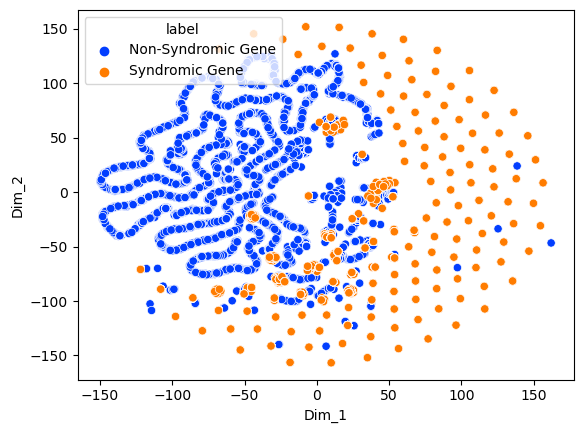

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.show()

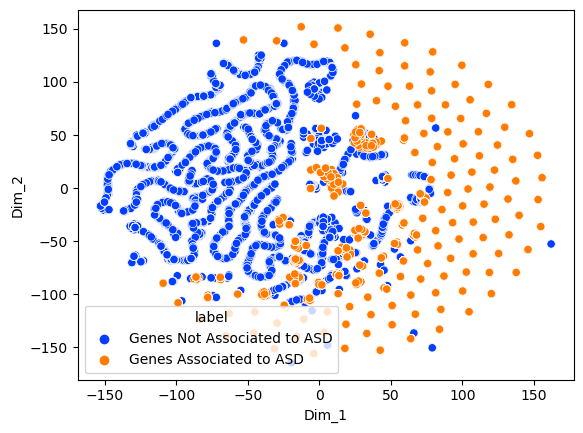

In [25]:
tsne_df=tsne_df[tsne_df['label']!=0]
import seaborn as sns
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.show()

In [26]:
len(idx_train)

12000

In [27]:
len(idx_val)

2400

In [28]:
torch.save(output, 'GraphSage_Upsample_output.pt')

In [29]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach().numpy()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()

In [30]:
c_out=output.cpu().detach()

In [31]:
test_outputs=c_out[cidx_test]

In [32]:
len(clabels[cidx_test])

8463

Text(0.5, 427.9555555555555, 'Predicted label')

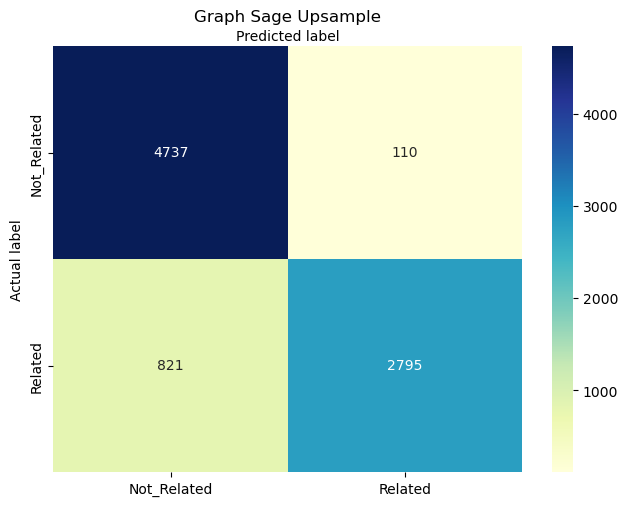

In [33]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
cnf_matrix_n[0][0]

4737

In [35]:
import sklearn

In [36]:
print(sklearn.metrics.classification_report(clabels[cidx_test], cout[cidx_test], target_names=class_names))

              precision    recall  f1-score   support

 Not_Related       0.85      0.98      0.91      4847
     Related       0.96      0.77      0.86      3616

    accuracy                           0.89      8463
   macro avg       0.91      0.88      0.88      8463
weighted avg       0.90      0.89      0.89      8463



In [37]:
cnf_matrix_n

array([[4737,  110],
       [ 821, 2795]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

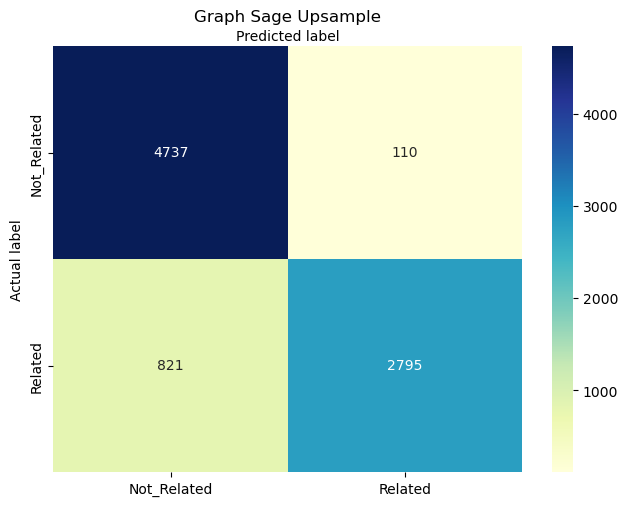

In [38]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n_valid = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [39]:
false_positive_test=cnf_matrix_n[0][1]
true_positive_test=cnf_matrix_n[1][1]
true_negative_test=cnf_matrix_n[0][0]
false_negative_test=cnf_matrix_n[1][0]

false_positive_valid=cnf_matrix_n_valid[0][1]
true_positive_valid=cnf_matrix_n_valid[1][1]
true_negative_valid=cnf_matrix_n_valid[0][0]
false_negative_valid=cnf_matrix_n_valid[1][0]

In [40]:
def specificity(true_negative,false_positive):
    return str(true_negative/(true_negative+false_positive))
def sensitivity(true_positive,false_negative):
    return str(true_positive/(true_positive+false_negative))

In [41]:
print('test')
print("Specificity: "+ specificity(true_negative_test,false_positive_test))
print("Sensitivity: "+ sensitivity(true_positive_test,false_negative_test))


test
Specificity: 0.9773055498246338
Sensitivity: 0.7729535398230089


In [42]:
print('validation')
print("Specificity: "+ specificity(true_negative_valid,false_positive_valid))
print("Sensitivity: "+sensitivity(true_positive_valid,false_negative_valid))


validation
Specificity: 0.9675
Sensitivity: 0.7616666666666667


In [43]:
test_labels=clabels[cidx_test]
test_output=cout[cidx_test]
valid_labels=clabels[cidx_valid]
valid_output=cout[cidx_valid]

In [44]:
test_labels_enc=np.eye(2)[test_labels]
test_output_enc=np.eye(2)[test_output]
valid_labels_enc=np.eye(2)[valid_labels]
valid_output_enc=np.eye(2)[valid_output]

In [45]:
roc_auc_score(clabels[cidx_test], cout[cidx_test])

0.8751295448238213

In [46]:
roc_auc_score(clabels[cidx_valid], cout[cidx_valid])

0.8645833333333334

In [47]:
conf, classes = torch.max(torch.nn.functional.softmax(output[:len(g.nodes())],dim=1), 1)

In [48]:
g_nodes=np.array(g.nodes())

In [49]:
c_conf=conf.cpu().detach().numpy()
c_classes=classes.cpu().detach().numpy()

In [50]:
confidence=[]
for i in range(len(g_nodes)):
    confidence.append([g_nodes[i],c_classes[i],clabels[i],c_conf[i]])

In [51]:
df_gene_confidence=pd.DataFrame(confidence,columns=['Gene','Predicted Class','Actual Class','Confidence'])

In [52]:
df_gene_confidence[df_gene_confidence['Predicted Class']==0].sort_values('Confidence',ascending=False).head(10)

,Gene,Predicted Class,Actual Class,Confidence
6193,APLNR,0,0,1.0
10918,c-SRC,0,0,1.0
6182,ICA1,0,0,1.0
6183,KXD1,0,0,1.0
6185,OAS1,0,0,1.0
6186,OPRM1,0,0,1.0
6187,PNKD,0,0,1.0
6188,PTK6,0,0,1.0
6189,PYCARD,0,0,1.0
1,ASGR1,0,0,1.0


In [53]:
df_gene_confidence.to_csv("Confidence_rates_syndromic-class.csv")

In [54]:
dummy_labels=pd.get_dummies(clabels[cidx_test]).values
dummy_preds=pd.get_dummies(cout[cidx_test]).values

In [55]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [56]:
test_outputs=torch.nn.functional.log_softmax(test_outputs)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\1996762243.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  test_outputs=torch.nn.functional.log_softmax(test_outputs)


In [57]:
test_outputs

tensor([[-4.3105e-01, -1.0493e+00],
        [-4.6892e-01, -9.8264e-01],
        [-2.2201e-03, -6.1113e+00],
        ...,
        [-3.4190e+00, -3.3293e-02],
        [-2.2376e+01,  0.0000e+00],
        [-2.5638e+01,  0.0000e+00]])

In [58]:
from sklearn import metrics
fpr=[]
tpr=[]
roc_auc=[]
import matplotlib.pyplot as plt
for i in range(1,2):
        fpr_, tpr_, _ = metrics.roc_curve(dummy_labels[:, i], test_outputs[:, i])
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(roc_auc_score(dummy_labels[:, i], test_outputs[:, i]))

In [59]:
output.max(1)[0]

tensor([ 2.4818, 31.7335,  2.0418,  ...,  0.7178, 13.4588,  2.5889],
       device='cuda:0', grad_fn=<MaxBackward0>)

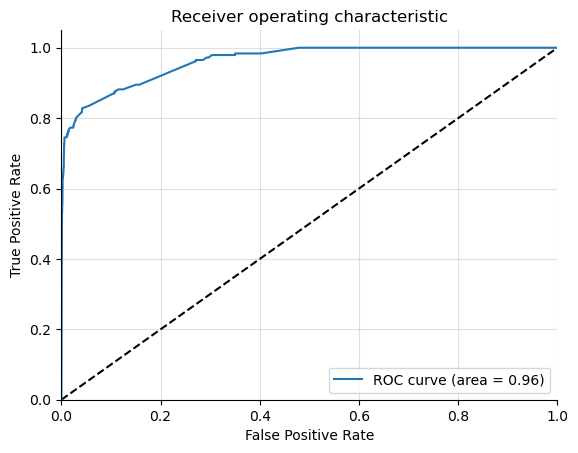

In [60]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
labels=['Genes Not Associated to ASD',"Genes Associated to ASD"]
for i in range(1):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % (roc_auc[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [61]:
test_output

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [62]:
fpr

[array([0.00000000e+00, 6.18939550e-04, 8.25252734e-04, 8.25252734e-04,
        8.25252734e-04, 8.25252734e-04, 8.25252734e-04, 8.25252734e-04,
        8.25252734e-04, 8.25252734e-04, 8.25252734e-04, 8.25252734e-04,
        8.25252734e-04, 8.25252734e-04, 8.25252734e-04, 1.03156592e-03,
        1.03156592e-03, 1.03156592e-03, 1.03156592e-03, 1.03156592e-03,
        1.03156592e-03, 1.03156592e-03, 1.23787910e-03, 1.23787910e-03,
        1.23787910e-03, 1.23787910e-03, 1.23787910e-03, 1.23787910e-03,
        1.65050547e-03, 1.65050547e-03, 1.65050547e-03, 1.65050547e-03,
        1.65050547e-03, 2.06313183e-03, 2.06313183e-03, 2.06313183e-03,
        2.26944502e-03, 2.26944502e-03, 2.26944502e-03, 2.26944502e-03,
        2.26944502e-03, 2.26944502e-03, 2.47575820e-03, 2.47575820e-03,
        2.47575820e-03, 2.47575820e-03, 3.09469775e-03, 3.09469775e-03,
        3.50732412e-03, 3.50732412e-03, 3.71363730e-03, 4.12626367e-03,
        4.12626367e-03, 4.12626367e-03, 4.33257685e-03, 4.332576

In [63]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn import metrics
precisions=[]
recalls=[]
import matplotlib.pyplot as plt
for i in range(2):
        precision, recall, _ = precision_recall_curve(dummy_labels[:, i], test_outputs[:, i])
        precisions.append(precision)
        recalls.append(recall)

In [64]:
test_labels_enc

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

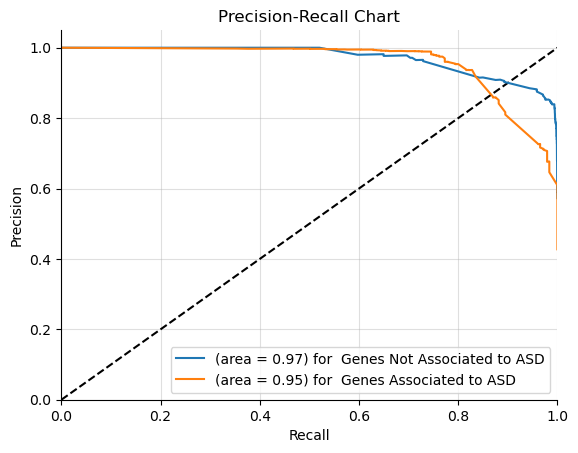

In [65]:
from sklearn.metrics import f1_score,precision_score,average_precision_score
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Chart')
ap=average_precision_score(test_labels_enc, test_outputs,average=None)
labels=['Genes Not Associated to ASD',"Genes Associated to ASD"]
for i in range(2):
    ax.plot(recalls[i], precisions[i], label='(area = %0.2f) for  %s' % (ap[i], labels[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [66]:
average_precision_score(test_labels, test_output,average=None)

0.8406955916855994

In [67]:
f1_score(test_labels_enc, test_output_enc,average='weighted')

0.887753070030178

In [68]:
valid_outputs=c_out[cidx_valid]

In [69]:
valid_outputs=torch.nn.functional.log_softmax(valid_outputs)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_18956\3970446506.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  valid_outputs=torch.nn.functional.log_softmax(valid_outputs)


In [70]:
average_precision_score(valid_labels, valid_output,average=None)

0.8496633438265129

In [71]:
f1_score(valid_labels_enc, valid_output_enc,average='weighted')

0.8631336669947367